# Set up environment

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
# Test if GPU is available
# Note that CUDA below 12.1 can have bugs
import torch
print(torch.cuda.is_available())
# print(torch.cuda.get_device_name(0))
print(torch.version.cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True
12.1


In [ ]:
#%% import libraries
import os
from collections import defaultdict
import sys

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import copy
import numpy as np
import numpy.random
from numpy.fft import fft as fft
from numpy.fft import ifft as ifft
import pickle
from sklearn.linear_model import PoissonRegressor
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
import scipy.stats
from scipy.stats import wilcoxon, chi2
import scipy.interpolate 
import scipy.signal
from scipy import linalg
from scipy.special import rel_entr
from tqdm import tqdm
import pandas as pd
import joblib
import logging

import statsmodels.api as sm
import statsmodels.genmod.generalized_linear_model as smm

import torch
from torch.autograd import Variable
from torch.nn import functional as F
import torch.nn as nn
import torch.optim as optim

In [ ]:
# import my code
import utility_functions as utils
import GLM
from DataLoader import Allen_dataset, Allen_dataloader_multi_session, Simple_dataloader_from_spikes
from model_trainer import Trainer

utils.set_seed(0)

/home/qix/anaconda3/envs/allen/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Correlated background but no synapse

In [ ]:
######### Settings #########
external_input_params = {
    "external_input_type": "two_peaks_with_all_varying",
    "std1": 10,
    "corr1": 0.5,
    "std2": 25,
    "corr2": 0.5,
    "use_two_modes": False,
    "gp_time_constant": 300,
    "gp_amplitude": 0.05,
}

conn = 0.0
nneuron_coupling = 10
nneuron = 100
nneuron_part = nneuron//2
npadding = 50
############################
for shared_background in [0.0, 0.2, 0.4]:
    spikes, trial_info, I_ext, I_syn = GLM.EIF_simulator(
        ntrial=2000,
        nneuron=nneuron,
        conn=conn,
        nneuron_coupling=nneuron_coupling,
        params=external_input_params,
        shared_background=shared_background,
        return_trial_info=True,
        return_I_ext=True,
        return_I_syn=True,
    )
    file_name = f'/home/qix/user_data/EIF_simulation_dataset/synthetic_data_EIF_conn={str(conn)}_corr={shared_background}.npz'
    np.savez_compressed(file_name,
                        spikes=spikes,
                        trial_info=trial_info,
                        I_ext=I_ext,
                        I_syn=I_syn)



100%|██████████| 2000/2000 [02:49<00:00, 11.82it/s]


In [ ]:
rcd_for_plot = {}
rcd_for_plot_base_model = {}
for shared_background in [0.0, 0.2, 0.4]:
    load_data_name = f'/home/qix/user_data/EIF_simulation_dataset/synthetic_data_EIF_conn={str(conn)}_corr={shared_background}.npz'

    data = np.load(load_data_name, allow_pickle=True)
    spikes = data['spikes']
    trial_info = data['trial_info']
    I_ext = data['I_ext']
    I_syn = data['I_syn']

    synthetic_dataloader = Simple_dataloader_from_spikes(
        [spikes[:,:nneuron_part,:], spikes[:,nneuron_part:,:]],
        npadding=50,
        train_ratio=0.7,
        val_ratio=0.1,
        batch_size=64,
        verbose=True
    )

    FIT_THE_BASELINE_MODEL = False

    # data_to_use = cross_session_dataloader
    data_to_use = synthetic_dataloader
    ckp_path = '/home/qix/user_data/VAETransformer_checkpoint'

    params = {
        # B-spline basis
        'num_B_spline_basis': 20,
        # Transformer VAE's settings
        'downsample_factor': 10,
        'transformer_num_layers': 2,
        'transformer_d_model': 128,
        'transformer_dim_feedforward': 512,
        'transformer_vae_output_dim': 16,
        'transformer_dropout': 0.0,
        'transformer_nhead': 1,
        'stimulus_nfactor': 1,
        'stimulus_decoder_inter_dim_factor': 2,
        'beta': 1.0,
        'use_area_specific_decoder': True,
        'use_area_specific_encoder': True,
        'use_cls': False,
        # Coupling's settings
        'coupling_basis_peaks_max': 5,
        'coupling_basis_num': 3,
        'coupling_nsubspace': 1,
        'use_self_coupling': True,
        # Coupling strength latent's settings
        'K_sigma2': 1.0,
        'K_tau': 100,
        'coupling_strength_nlatent': 1,
        # Self-history's settings
        'self_history_basis_peaks_max': 1.5,
        'self_history_basis_num': 3,
        'self_history_basis_nonlinear': 1,
        # Penalty settings
        'penalty_smoothing_spline': 1e2,
        'penalty_effect_overlapping': None, 
        'penalty_coupling_subgroup': 1e-4,
        'penalty_diff_loading': None,
        # Training settings
        'batch_size': 64,
        'sample_latent': False,
        'lr': 1e-3,
        'epoch_warm_up': 0,
        'epoch_patience': 3,
        'epoch_max': 200,
        'tol': 1e-5,
        'weight_decay': 0,
        'lr_transformer': 1e-4,
        'lr_sti': 1e-2,
        'lr_cp': 1e-2,
    }

    trainer = Trainer(data_to_use, ckp_path, params)

    if FIT_THE_BASELINE_MODEL:
        # Baseline model: no trial-varying stimulus effect
        trainer.train(
            include_stimulus=True,
            include_coupling=True,
            fix_stimulus=True,
            fix_latents=True,
            verbose=True,
        )

    else:
        # First step: train the model with a trial-invariant stimulus effect
        trainer.train(
            include_stimulus=True,
            include_coupling=False,
            fix_stimulus=True,
            fix_latents=True,
            verbose=True,
        )
        # Second step: train the model with a trial-varying stimulus effect
        # trainer.make_optimizer(frozen_params=['sti_readout'])
        trainer.make_optimizer(frozen_params=['sti_inhomo', ]) # We are fixing the trial-invariant stimulus effect
        trainer.train(
            include_stimulus=True,
            include_coupling=False,
            fix_stimulus=False,
            fix_latents=True,
            verbose=True,
        )

        trainer.make_optimizer(frozen_params=['transformer_encoder', 'to_latent', 'token_converter'])
        # trainer.make_optimizer(frozen_params=[])
        trainer.train(
            include_stimulus=True,
            include_coupling=True,
            fix_stimulus=False,
            fix_latents=True,
            verbose=True,
        )


    ### Which dataset to use?
    loader = trainer.dataloader.test_loader

    ###
    trainer.model.normalize_coupling_coefficients()
    trainer.model.eval()
    trainer.model.sample_latent = False
    test_loss = 0.0
    test_loss_baseline = 0.0
    total_trial = 0
    test_loss_record = []
    with torch.no_grad():
        for i, batch in enumerate(tqdm(loader)):
            trainer.process_batch(batch)
            firing_rate = trainer.model(
                batch,
                include_stimulus=True,
                include_coupling=True,
                fix_stimulus=False,
                fix_latents=True,
            )
            loss = trainer.model.loss_function(
                firing_rate, 
                batch["spike_trains"][trainer.npadding:,:,:], 
                trainer.model.sti_mu, 
                trainer.model.sti_logvar, 
                beta=trainer.params['beta']
            )
            test_loss_record.append(loss.item())
            test_loss += loss.item() * batch["spike_trains"].size(2)
            total_trial += batch["spike_trains"].size(2)
            if i==0 or firing_rate_baseline.shape != batch["spike_trains"][trainer.npadding:,:,:].shape:
                firing_rate_baseline = (
                    torch.log(torch.clamp(batch["spike_trains"][trainer.npadding:,:,:].mean(dim=(0,2)), min=1e-4))[None,:,None] \
                        * torch.ones_like(batch["spike_trains"][trainer.npadding:,:,:])
                )
            
            loss_baseline = trainer.model.loss_function(
                firing_rate_baseline, 
                batch["spike_trains"][trainer.npadding:,:,:], 
                trainer.model.sti_mu, 
                trainer.model.sti_logvar, 
                beta=trainer.params['beta']
            )
            test_loss_baseline += loss_baseline.item() * batch["spike_trains"].size(2)

    test_loss /= total_trial
    test_loss_baseline /= total_trial
    print(f"Test loss: {test_loss}")
    print(f"Test loss baseline: {test_loss_baseline}")

    firing_rate_test, sti_mu_test, sti_logvar_test, trial_indices, spike_train_test = trainer.predict(
        dataset='test',
        batch_indices=[0],
        include_stimulus=True,
        include_coupling=True,
        fix_stimulus=False,
        fix_latents=True,
        return_torch=True,
        return_trial_indices=True,
        return_spike_trains=True,
    )

    neuron_indices = np.arange(nneuron_part,nneuron_part+nneuron_coupling)
    rcd_for_plot[shared_background] = {
        'I_ext': I_ext[:, :, trial_indices][:, neuron_indices, :],
        'I_syn': I_syn[:, :, trial_indices][:, neuron_indices, :],
        'firing_rates_stimulus': trainer.model.firing_rates_stimulus[:, neuron_indices, :].cpu().numpy().transpose(2,1,0),
        'firing_rates_coupling': trainer.model.coupling_outputs_subspace[0][1][:, :nneuron_coupling, :].cpu().numpy().transpose(2,1,0),
        'firing_rates_total': firing_rate_test[:, :nneuron_coupling, :].cpu().numpy(),
    }


    ################## Fit the baseline model ##################
    FIT_THE_BASELINE_MODEL = True

    # data_to_use = cross_session_dataloader
    data_to_use = synthetic_dataloader
    ckp_path = '/home/qix/user_data/VAETransformer_checkpoint'

    params = {
        # B-spline basis
        'num_B_spline_basis': 20,
        # Transformer VAE's settings
        'downsample_factor': 10,
        'transformer_num_layers': 2,
        'transformer_d_model': 128,
        'transformer_dim_feedforward': 512,
        'transformer_vae_output_dim': 16,
        'transformer_dropout': 0.0,
        'transformer_nhead': 1,
        'stimulus_nfactor': 1,
        'stimulus_decoder_inter_dim_factor': 2,
        'beta': 1.0,
        'use_area_specific_decoder': True,
        'use_area_specific_encoder': True,
        'use_cls': False,
        # Coupling's settings
        'coupling_basis_peaks_max': 5,
        'coupling_basis_num': 3,
        'coupling_nsubspace': 1,
        'use_self_coupling': True,
        # Coupling strength latent's settings
        'K_sigma2': 1.0,
        'K_tau': 100,
        'coupling_strength_nlatent': 1,
        # Penalty settings
        'penalty_smoothing_spline': 1e2,
        'penalty_effect_overlapping': None, 
        'penalty_coupling_subgroup': 1e-4,
        'penalty_diff_loading': None,
        # Training settings
        'batch_size': 64,
        'sample_latent': False,
        'lr': 1e-3,
        'epoch_warm_up': 0,
        'epoch_patience': 3,
        'epoch_max': 200,
        'tol': 1e-5,
        'weight_decay': 0,
        'lr_transformer': 1e-4,
        'lr_sti': 1e-2,
        'lr_cp': 1e-2,
    }

    trainer = Trainer(data_to_use, ckp_path, params)

    if FIT_THE_BASELINE_MODEL:
        # Baseline model: no trial-varying stimulus effect
        trainer.train(
            include_stimulus=True,
            include_coupling=True,
            fix_stimulus=True,
            fix_latents=True,
            verbose=True,
        )

    else:
        # First step: train the model with a trial-invariant stimulus effect
        trainer.train(
            include_stimulus=True,
            include_coupling=False,
            fix_stimulus=True,
            fix_latents=True,
            verbose=True,
        )
        # Second step: train the model with a trial-varying stimulus effect
        # trainer.make_optimizer(frozen_params=['sti_readout'])
        trainer.make_optimizer(frozen_params=['sti_inhomo', ]) # We are fixing the trial-invariant stimulus effect
        trainer.train(
            include_stimulus=True,
            include_coupling=False,
            fix_stimulus=False,
            fix_latents=True,
            verbose=True,
        )

        trainer.make_optimizer(frozen_params=['transformer_encoder', 'to_latent', 'token_converter'])
        # trainer.make_optimizer(frozen_params=[])
        trainer.train(
            include_stimulus=True,
            include_coupling=True,
            fix_stimulus=False,
            fix_latents=True,
            verbose=True,
        )


    ### Which dataset to use?
    loader = trainer.dataloader.test_loader

    ###
    trainer.model.normalize_coupling_coefficients()
    trainer.model.eval()
    trainer.model.sample_latent = False
    test_loss = 0.0
    test_loss_baseline = 0.0
    total_trial = 0
    test_loss_record = []
    with torch.no_grad():
        for i, batch in enumerate(tqdm(loader)):
            trainer.process_batch(batch)
            firing_rate = trainer.model(
                batch,
                include_stimulus=True,
                include_coupling=True,
                fix_stimulus=False,
                fix_latents=True,
            )
            loss = trainer.model.loss_function(
                firing_rate, 
                batch["spike_trains"][trainer.npadding:,:,:], 
                trainer.model.sti_mu, 
                trainer.model.sti_logvar, 
                beta=trainer.params['beta']
            )
            test_loss_record.append(loss.item())
            test_loss += loss.item() * batch["spike_trains"].size(2)
            total_trial += batch["spike_trains"].size(2)
            if i==0 or firing_rate_baseline.shape != batch["spike_trains"][trainer.npadding:,:,:].shape:
                firing_rate_baseline = (
                    torch.log(torch.clamp(batch["spike_trains"][trainer.npadding:,:,:].mean(dim=(0,2)), min=1e-4))[None,:,None] \
                        * torch.ones_like(batch["spike_trains"][trainer.npadding:,:,:])
                )
            
            loss_baseline = trainer.model.loss_function(
                firing_rate_baseline, 
                batch["spike_trains"][trainer.npadding:,:,:], 
                trainer.model.sti_mu, 
                trainer.model.sti_logvar, 
                beta=trainer.params['beta']
            )
            test_loss_baseline += loss_baseline.item() * batch["spike_trains"].size(2)

    test_loss /= total_trial
    test_loss_baseline /= total_trial
    print(f"Test loss: {test_loss}")
    print(f"Test loss baseline: {test_loss_baseline}")

    firing_rate_test, sti_mu_test, sti_logvar_test, trial_indices, spike_train_test = trainer.predict(
        dataset='test',
        batch_indices=[0],
        include_stimulus=True,
        include_coupling=True,
        fix_stimulus=False,
        fix_latents=True,
        return_torch=True,
        return_trial_indices=True,
        return_spike_trains=True,
    )

    neuron_indices = np.arange(nneuron_part,nneuron_part+nneuron_coupling)
    rcd_for_plot_base_model[shared_background] = {
        'I_ext': I_ext[:, :, trial_indices][:, neuron_indices, :],
        'I_syn': I_syn[:, :, trial_indices][:, neuron_indices, :],
        'firing_rates_stimulus': trainer.model.firing_rates_stimulus[:, neuron_indices, :].cpu().numpy().transpose(2,1,0),
        'firing_rates_coupling': trainer.model.coupling_outputs_subspace[0][1][:, :nneuron_coupling, :].cpu().numpy().transpose(2,1,0),
        'firing_rates_total': firing_rate_test[:, :nneuron_coupling, :].cpu().numpy(),
    }

Model initialized. Training on cuda
Start training model with parameters: {'num_B_spline_basis': 20, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 16, 'transformer_dropout': 0.0, 'transformer_nhead': 1, 'stimulus_nfactor': 1, 'stimulus_decoder_inter_dim_factor': 2, 'beta': 1.0, 'use_area_specific_decoder': True, 'use_area_specific_encoder': True, 'use_cls': False, 'coupling_basis_peaks_max': 5, 'coupling_basis_num': 3, 'coupling_nsubspace': 1, 'use_self_coupling': True, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'penalty_smoothing_spline': 100.0, 'penalty_effect_overlapping': None, 'penalty_coupling_subgroup': 0.0001, 'penalty_diff_loading': None, 'batch_size': 64, 'sample_latent': False, 'lr': 0.001, 'epoch_warm_up': 0, 'epoch_patience': 3, 'epoch_max': 200, 'tol': 1e-05, 'weight_decay': 0, 'lr_transformer': 0.0001, 'lr_sti': 0.01, 'lr_cp': 0.01}


100%|██████████| 4/4 [00:00<00:00, 290.85it/s]


Epoch 1/200, Train Loss: 1.0329, Test Loss: 0.8741


100%|██████████| 4/4 [00:00<00:00, 295.25it/s]


Epoch 2/200, Train Loss: 0.7309, Test Loss: 0.5783


100%|██████████| 4/4 [00:00<00:00, 294.55it/s]


Epoch 3/200, Train Loss: 0.4732, Test Loss: 0.3739


100%|██████████| 4/4 [00:00<00:00, 290.42it/s]


Epoch 4/200, Train Loss: 0.3262, Test Loss: 0.2818


100%|██████████| 4/4 [00:00<00:00, 291.22it/s]


Epoch 5/200, Train Loss: 0.2675, Test Loss: 0.2487


100%|██████████| 4/4 [00:00<00:00, 280.19it/s]


Epoch 6/200, Train Loss: 0.2464, Test Loss: 0.2361


100%|██████████| 4/4 [00:00<00:00, 262.74it/s]


Epoch 7/200, Train Loss: 0.2378, Test Loss: 0.2305


100%|██████████| 4/4 [00:00<00:00, 285.47it/s]


Epoch 8/200, Train Loss: 0.2339, Test Loss: 0.2277


100%|██████████| 4/4 [00:00<00:00, 280.53it/s]


Epoch 9/200, Train Loss: 0.2318, Test Loss: 0.2262


100%|██████████| 4/4 [00:00<00:00, 267.84it/s]


Epoch 10/200, Train Loss: 0.2307, Test Loss: 0.2253


100%|██████████| 4/4 [00:00<00:00, 259.83it/s]


Epoch 11/200, Train Loss: 0.2300, Test Loss: 0.2248


100%|██████████| 4/4 [00:00<00:00, 249.85it/s]


Epoch 12/200, Train Loss: 0.2296, Test Loss: 0.2245


100%|██████████| 4/4 [00:00<00:00, 279.31it/s]


Epoch 13/200, Train Loss: 0.2293, Test Loss: 0.2243


100%|██████████| 4/4 [00:00<00:00, 244.01it/s]


Epoch 14/200, Train Loss: 0.2292, Test Loss: 0.2242


100%|██████████| 4/4 [00:00<00:00, 293.75it/s]


Epoch 15/200, Train Loss: 0.2291, Test Loss: 0.2241


100%|██████████| 4/4 [00:00<00:00, 279.75it/s]


Epoch 16/200, Train Loss: 0.2290, Test Loss: 0.2240


100%|██████████| 4/4 [00:00<00:00, 299.83it/s]


Epoch 17/200, Train Loss: 0.2290, Test Loss: 0.2240


100%|██████████| 4/4 [00:00<00:00, 293.02it/s]


Epoch 18/200, Train Loss: 0.2289, Test Loss: 0.2240


100%|██████████| 4/4 [00:00<00:00, 284.92it/s]


Epoch 19/200, Train Loss: 0.2289, Test Loss: 0.2239


100%|██████████| 4/4 [00:00<00:00, 273.55it/s]


Epoch 20/200, Train Loss: 0.2289, Test Loss: 0.2239


100%|██████████| 4/4 [00:00<00:00, 276.52it/s]


Epoch 21/200, Train Loss: 0.2289, Test Loss: 0.2239
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2239


100%|██████████| 4/4 [00:00<00:00, 232.80it/s]


Epoch 22/200, Train Loss: 0.2289, Test Loss: 0.2239


100%|██████████| 4/4 [00:00<00:00, 216.96it/s]


Epoch 23/200, Train Loss: 0.2289, Test Loss: 0.2239
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2239


100%|██████████| 4/4 [00:00<00:00, 255.12it/s]


Epoch 24/200, Train Loss: 0.2289, Test Loss: 0.2239
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2239


100%|██████████| 4/4 [00:00<00:00, 181.18it/s]


Epoch 25/200, Train Loss: 0.2289, Test Loss: 0.2239


100%|██████████| 4/4 [00:00<00:00, 226.19it/s]


Epoch 26/200, Train Loss: 0.2289, Test Loss: 0.2239
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2239


100%|██████████| 4/4 [00:00<00:00, 267.90it/s]


Epoch 27/200, Train Loss: 0.2289, Test Loss: 0.2239
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2239


100%|██████████| 4/4 [00:00<00:00, 277.69it/s]


Epoch 28/200, Train Loss: 0.2289, Test Loss: 0.2239
No improvement in Test Loss for 3 epoch(s).
Current Best Test Loss: 0.2239
Early stopping triggered.
Start training model with parameters: {'num_B_spline_basis': 20, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 16, 'transformer_dropout': 0.0, 'transformer_nhead': 1, 'stimulus_nfactor': 1, 'stimulus_decoder_inter_dim_factor': 2, 'beta': 1.0, 'use_area_specific_decoder': True, 'use_area_specific_encoder': True, 'use_cls': False, 'coupling_basis_peaks_max': 5, 'coupling_basis_num': 3, 'coupling_nsubspace': 1, 'use_self_coupling': True, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'penalty_smoothing_spline': 100.0, 'penalty_effect_overlapping': None, 'penalty_coupling_subgroup': 0.0001, 'penalty_diff_loading': None, 'batch_size': 64, 'sample_latent': False, 'lr': 0.001, 'epoch_warm_up': 0, 'epoch_patience': 3, 'epoch_ma

100%|██████████| 4/4 [00:00<00:00, 214.50it/s]


Epoch 1/200, Train Loss: 0.2336, Test Loss: 0.2227


100%|██████████| 4/4 [00:00<00:00, 214.60it/s]


Epoch 2/200, Train Loss: 0.2273, Test Loss: 0.2218


100%|██████████| 4/4 [00:00<00:00, 185.10it/s]


Epoch 3/200, Train Loss: 0.2269, Test Loss: 0.2216


100%|██████████| 4/4 [00:00<00:00, 163.66it/s]


Epoch 4/200, Train Loss: 0.2268, Test Loss: 0.2215


100%|██████████| 4/4 [00:00<00:00, 222.57it/s]


Epoch 5/200, Train Loss: 0.2267, Test Loss: 0.2214


100%|██████████| 4/4 [00:00<00:00, 229.82it/s]


Epoch 6/200, Train Loss: 0.2266, Test Loss: 0.2213


100%|██████████| 4/4 [00:00<00:00, 220.47it/s]


Epoch 7/200, Train Loss: 0.2265, Test Loss: 0.2213


100%|██████████| 4/4 [00:00<00:00, 231.87it/s]


Epoch 8/200, Train Loss: 0.2264, Test Loss: 0.2211


100%|██████████| 4/4 [00:00<00:00, 225.81it/s]


Epoch 9/200, Train Loss: 0.2263, Test Loss: 0.2210


100%|██████████| 4/4 [00:00<00:00, 212.42it/s]


Epoch 10/200, Train Loss: 0.2261, Test Loss: 0.2208


100%|██████████| 4/4 [00:00<00:00, 216.96it/s]


Epoch 11/200, Train Loss: 0.2258, Test Loss: 0.2206


100%|██████████| 4/4 [00:00<00:00, 214.89it/s]


Epoch 12/200, Train Loss: 0.2257, Test Loss: 0.2204


100%|██████████| 4/4 [00:00<00:00, 165.48it/s]


Epoch 13/200, Train Loss: 0.2256, Test Loss: 0.2203


100%|██████████| 4/4 [00:00<00:00, 220.32it/s]


Epoch 14/200, Train Loss: 0.2255, Test Loss: 0.2202


100%|██████████| 4/4 [00:00<00:00, 133.49it/s]


Epoch 15/200, Train Loss: 0.2254, Test Loss: 0.2201


100%|██████████| 4/4 [00:00<00:00, 221.70it/s]


Epoch 16/200, Train Loss: 0.2252, Test Loss: 0.2199


100%|██████████| 4/4 [00:00<00:00, 199.29it/s]


Epoch 17/200, Train Loss: 0.2251, Test Loss: 0.2198


100%|██████████| 4/4 [00:00<00:00, 220.85it/s]


Epoch 18/200, Train Loss: 0.2250, Test Loss: 0.2196


100%|██████████| 4/4 [00:00<00:00, 219.78it/s]


Epoch 19/200, Train Loss: 0.2248, Test Loss: 0.2195


100%|██████████| 4/4 [00:00<00:00, 206.62it/s]


Epoch 20/200, Train Loss: 0.2247, Test Loss: 0.2195
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2195


100%|██████████| 4/4 [00:00<00:00, 219.73it/s]


Epoch 21/200, Train Loss: 0.2247, Test Loss: 0.2193


100%|██████████| 4/4 [00:00<00:00, 173.75it/s]


Epoch 22/200, Train Loss: 0.2246, Test Loss: 0.2193


100%|██████████| 4/4 [00:00<00:00, 182.99it/s]


Epoch 23/200, Train Loss: 0.2245, Test Loss: 0.2192


100%|██████████| 4/4 [00:00<00:00, 208.02it/s]


Epoch 24/200, Train Loss: 0.2244, Test Loss: 0.2191


100%|██████████| 4/4 [00:00<00:00, 152.35it/s]


Epoch 25/200, Train Loss: 0.2243, Test Loss: 0.2191


100%|██████████| 4/4 [00:00<00:00, 138.20it/s]


Epoch 26/200, Train Loss: 0.2243, Test Loss: 0.2190


100%|██████████| 4/4 [00:00<00:00, 141.45it/s]


Epoch 27/200, Train Loss: 0.2243, Test Loss: 0.2190


100%|██████████| 4/4 [00:00<00:00, 215.53it/s]


Epoch 28/200, Train Loss: 0.2242, Test Loss: 0.2190


100%|██████████| 4/4 [00:00<00:00, 216.74it/s]


Epoch 29/200, Train Loss: 0.2242, Test Loss: 0.2190


100%|██████████| 4/4 [00:00<00:00, 211.69it/s]


Epoch 30/200, Train Loss: 0.2242, Test Loss: 0.2189


100%|██████████| 4/4 [00:00<00:00, 211.41it/s]


Epoch 31/200, Train Loss: 0.2242, Test Loss: 0.2189


100%|██████████| 4/4 [00:00<00:00, 174.99it/s]


Epoch 32/200, Train Loss: 0.2242, Test Loss: 0.2189


100%|██████████| 4/4 [00:00<00:00, 214.61it/s]


Epoch 33/200, Train Loss: 0.2242, Test Loss: 0.2189


100%|██████████| 4/4 [00:00<00:00, 207.95it/s]


Epoch 34/200, Train Loss: 0.2242, Test Loss: 0.2189
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2189


100%|██████████| 4/4 [00:00<00:00, 228.74it/s]


Epoch 35/200, Train Loss: 0.2241, Test Loss: 0.2189
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2189


100%|██████████| 4/4 [00:00<00:00, 209.91it/s]


Epoch 36/200, Train Loss: 0.2241, Test Loss: 0.2189
No improvement in Test Loss for 3 epoch(s).
Current Best Test Loss: 0.2189
Early stopping triggered.
Start training model with parameters: {'num_B_spline_basis': 20, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 16, 'transformer_dropout': 0.0, 'transformer_nhead': 1, 'stimulus_nfactor': 1, 'stimulus_decoder_inter_dim_factor': 2, 'beta': 1.0, 'use_area_specific_decoder': True, 'use_area_specific_encoder': True, 'use_cls': False, 'coupling_basis_peaks_max': 5, 'coupling_basis_num': 3, 'coupling_nsubspace': 1, 'use_self_coupling': True, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'penalty_smoothing_spline': 100.0, 'penalty_effect_overlapping': None, 'penalty_coupling_subgroup': 0.0001, 'penalty_diff_loading': None, 'batch_size': 64, 'sample_latent': False, 'lr': 0.001, 'epoch_warm_up': 0, 'epoch_patience': 3, 'epoch_ma

100%|██████████| 4/4 [00:00<00:00, 177.87it/s]


Epoch 1/200, Train Loss: 0.2241, Test Loss: 0.2186


100%|██████████| 4/4 [00:00<00:00, 118.57it/s]


Epoch 2/200, Train Loss: 0.2238, Test Loss: 0.2185


100%|██████████| 4/4 [00:00<00:00, 176.11it/s]


Epoch 3/200, Train Loss: 0.2237, Test Loss: 0.2185


100%|██████████| 4/4 [00:00<00:00, 143.51it/s]


Epoch 4/200, Train Loss: 0.2237, Test Loss: 0.2184


100%|██████████| 4/4 [00:00<00:00, 172.08it/s]


Epoch 5/200, Train Loss: 0.2237, Test Loss: 0.2184


100%|██████████| 4/4 [00:00<00:00, 175.12it/s]


Epoch 6/200, Train Loss: 0.2237, Test Loss: 0.2184
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2184


100%|██████████| 4/4 [00:00<00:00, 183.42it/s]


Epoch 7/200, Train Loss: 0.2237, Test Loss: 0.2184


100%|██████████| 4/4 [00:00<00:00, 88.19it/s]


Epoch 8/200, Train Loss: 0.2237, Test Loss: 0.2184
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2184


100%|██████████| 4/4 [00:00<00:00, 155.67it/s]


Epoch 9/200, Train Loss: 0.2236, Test Loss: 0.2184
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2184


100%|██████████| 4/4 [00:00<00:00, 181.45it/s]


Epoch 10/200, Train Loss: 0.2236, Test Loss: 0.2184


100%|██████████| 4/4 [00:00<00:00, 182.90it/s]


Epoch 11/200, Train Loss: 0.2236, Test Loss: 0.2184
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2184


100%|██████████| 4/4 [00:00<00:00, 95.90it/s]


Epoch 12/200, Train Loss: 0.2236, Test Loss: 0.2184
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2184


100%|██████████| 4/4 [00:00<00:00, 145.39it/s]


Epoch 13/200, Train Loss: 0.2236, Test Loss: 0.2184
No improvement in Test Loss for 3 epoch(s).
Current Best Test Loss: 0.2184
Early stopping triggered.


100%|██████████| 7/7 [00:00<00:00, 97.86it/s]


Test loss: 0.22223396261136727
Test loss baseline: 0.23082217518379564
Model initialized. Training on cuda
Start training model with parameters: {'num_B_spline_basis': 20, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 16, 'transformer_dropout': 0.0, 'transformer_nhead': 1, 'stimulus_nfactor': 1, 'stimulus_decoder_inter_dim_factor': 2, 'beta': 1.0, 'use_area_specific_decoder': True, 'use_area_specific_encoder': True, 'use_cls': False, 'coupling_basis_peaks_max': 5, 'coupling_basis_num': 3, 'coupling_nsubspace': 1, 'use_self_coupling': True, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'penalty_smoothing_spline': 100.0, 'penalty_effect_overlapping': None, 'penalty_coupling_subgroup': 0.0001, 'penalty_diff_loading': None, 'batch_size': 64, 'sample_latent': False, 'lr': 0.001, 'epoch_warm_up': 0, 'epoch_patience': 3, 'epoch_max': 200, 'tol': 1e-05, 'weight_decay': 0, 'lr_

100%|██████████| 4/4 [00:00<00:00, 207.08it/s]


Epoch 1/200, Train Loss: 0.9283, Test Loss: 0.4978


100%|██████████| 4/4 [00:00<00:00, 226.68it/s]


Epoch 2/200, Train Loss: 0.3425, Test Loss: 0.3043


100%|██████████| 4/4 [00:00<00:00, 212.25it/s]


Epoch 3/200, Train Loss: 0.2962, Test Loss: 0.2839


100%|██████████| 4/4 [00:00<00:00, 227.59it/s]


Epoch 4/200, Train Loss: 0.2812, Test Loss: 0.2713


100%|██████████| 4/4 [00:00<00:00, 160.06it/s]


Epoch 5/200, Train Loss: 0.2717, Test Loss: 0.2625


100%|██████████| 4/4 [00:00<00:00, 217.83it/s]


Epoch 6/200, Train Loss: 0.2631, Test Loss: 0.2541


100%|██████████| 4/4 [00:00<00:00, 212.64it/s]


Epoch 7/200, Train Loss: 0.2552, Test Loss: 0.2466


100%|██████████| 4/4 [00:00<00:00, 216.69it/s]


Epoch 8/200, Train Loss: 0.2485, Test Loss: 0.2405


100%|██████████| 4/4 [00:00<00:00, 227.77it/s]


Epoch 9/200, Train Loss: 0.2431, Test Loss: 0.2357


100%|██████████| 4/4 [00:00<00:00, 225.05it/s]


Epoch 10/200, Train Loss: 0.2390, Test Loss: 0.2322


100%|██████████| 4/4 [00:00<00:00, 210.90it/s]


Epoch 11/200, Train Loss: 0.2361, Test Loss: 0.2297


100%|██████████| 4/4 [00:00<00:00, 224.57it/s]


Epoch 12/200, Train Loss: 0.2339, Test Loss: 0.2279


100%|██████████| 4/4 [00:00<00:00, 208.17it/s]


Epoch 13/200, Train Loss: 0.2324, Test Loss: 0.2267


100%|██████████| 4/4 [00:00<00:00, 229.08it/s]


Epoch 14/200, Train Loss: 0.2313, Test Loss: 0.2258


100%|██████████| 4/4 [00:00<00:00, 161.20it/s]


Epoch 15/200, Train Loss: 0.2305, Test Loss: 0.2251


100%|██████████| 4/4 [00:00<00:00, 204.15it/s]


Epoch 16/200, Train Loss: 0.2299, Test Loss: 0.2246


100%|██████████| 4/4 [00:00<00:00, 203.79it/s]


Epoch 17/200, Train Loss: 0.2295, Test Loss: 0.2243


100%|██████████| 4/4 [00:00<00:00, 186.07it/s]


Epoch 18/200, Train Loss: 0.2292, Test Loss: 0.2240


100%|██████████| 4/4 [00:00<00:00, 187.62it/s]


Epoch 19/200, Train Loss: 0.2289, Test Loss: 0.2238


100%|██████████| 4/4 [00:00<00:00, 205.98it/s]


Epoch 20/200, Train Loss: 0.2288, Test Loss: 0.2236


100%|██████████| 4/4 [00:00<00:00, 226.19it/s]


Epoch 21/200, Train Loss: 0.2286, Test Loss: 0.2235


100%|██████████| 4/4 [00:00<00:00, 205.85it/s]


Epoch 22/200, Train Loss: 0.2284, Test Loss: 0.2233


100%|██████████| 4/4 [00:00<00:00, 211.13it/s]


Epoch 23/200, Train Loss: 0.2283, Test Loss: 0.2232


100%|██████████| 4/4 [00:00<00:00, 88.06it/s]


Epoch 24/200, Train Loss: 0.2282, Test Loss: 0.2231


100%|██████████| 4/4 [00:00<00:00, 131.05it/s]


Epoch 25/200, Train Loss: 0.2280, Test Loss: 0.2229


100%|██████████| 4/4 [00:00<00:00, 185.88it/s]


Epoch 26/200, Train Loss: 0.2279, Test Loss: 0.2228


100%|██████████| 4/4 [00:00<00:00, 122.03it/s]


Epoch 27/200, Train Loss: 0.2278, Test Loss: 0.2227


100%|██████████| 4/4 [00:00<00:00, 114.30it/s]


Epoch 28/200, Train Loss: 0.2276, Test Loss: 0.2225


100%|██████████| 4/4 [00:00<00:00, 148.36it/s]


Epoch 29/200, Train Loss: 0.2275, Test Loss: 0.2224


100%|██████████| 4/4 [00:00<00:00, 143.46it/s]


Epoch 30/200, Train Loss: 0.2274, Test Loss: 0.2222


100%|██████████| 4/4 [00:00<00:00, 187.53it/s]


Epoch 31/200, Train Loss: 0.2272, Test Loss: 0.2221


100%|██████████| 4/4 [00:00<00:00, 180.40it/s]


Epoch 32/200, Train Loss: 0.2270, Test Loss: 0.2219


100%|██████████| 4/4 [00:00<00:00, 217.52it/s]


Epoch 33/200, Train Loss: 0.2269, Test Loss: 0.2217


100%|██████████| 4/4 [00:00<00:00, 204.78it/s]


Epoch 34/200, Train Loss: 0.2267, Test Loss: 0.2216


100%|██████████| 4/4 [00:00<00:00, 146.28it/s]


Epoch 35/200, Train Loss: 0.2266, Test Loss: 0.2214


100%|██████████| 4/4 [00:00<00:00, 206.63it/s]


Epoch 36/200, Train Loss: 0.2264, Test Loss: 0.2213


100%|██████████| 4/4 [00:00<00:00, 216.75it/s]


Epoch 37/200, Train Loss: 0.2263, Test Loss: 0.2211


100%|██████████| 4/4 [00:00<00:00, 221.84it/s]


Epoch 38/200, Train Loss: 0.2261, Test Loss: 0.2210


100%|██████████| 4/4 [00:00<00:00, 209.84it/s]


Epoch 39/200, Train Loss: 0.2260, Test Loss: 0.2208


100%|██████████| 4/4 [00:00<00:00, 143.03it/s]


Epoch 40/200, Train Loss: 0.2259, Test Loss: 0.2207


100%|██████████| 4/4 [00:00<00:00, 214.78it/s]


Epoch 41/200, Train Loss: 0.2258, Test Loss: 0.2206


100%|██████████| 4/4 [00:00<00:00, 212.24it/s]


Epoch 42/200, Train Loss: 0.2257, Test Loss: 0.2205


100%|██████████| 4/4 [00:00<00:00, 220.45it/s]


Epoch 43/200, Train Loss: 0.2256, Test Loss: 0.2204


100%|██████████| 4/4 [00:00<00:00, 215.96it/s]


Epoch 44/200, Train Loss: 0.2255, Test Loss: 0.2204


100%|██████████| 4/4 [00:00<00:00, 221.70it/s]


Epoch 45/200, Train Loss: 0.2255, Test Loss: 0.2203


100%|██████████| 4/4 [00:00<00:00, 209.07it/s]


Epoch 46/200, Train Loss: 0.2254, Test Loss: 0.2202


100%|██████████| 4/4 [00:00<00:00, 223.29it/s]


Epoch 47/200, Train Loss: 0.2253, Test Loss: 0.2202


100%|██████████| 4/4 [00:00<00:00, 212.50it/s]


Epoch 48/200, Train Loss: 0.2253, Test Loss: 0.2201


100%|██████████| 4/4 [00:00<00:00, 232.41it/s]


Epoch 49/200, Train Loss: 0.2253, Test Loss: 0.2201


100%|██████████| 4/4 [00:00<00:00, 230.11it/s]


Epoch 50/200, Train Loss: 0.2252, Test Loss: 0.2201


100%|██████████| 4/4 [00:00<00:00, 224.90it/s]


Epoch 51/200, Train Loss: 0.2252, Test Loss: 0.2201


100%|██████████| 4/4 [00:00<00:00, 201.82it/s]


Epoch 52/200, Train Loss: 0.2252, Test Loss: 0.2200


100%|██████████| 4/4 [00:00<00:00, 224.97it/s]


Epoch 53/200, Train Loss: 0.2252, Test Loss: 0.2200


100%|██████████| 4/4 [00:00<00:00, 227.46it/s]


Epoch 54/200, Train Loss: 0.2252, Test Loss: 0.2200


100%|██████████| 4/4 [00:00<00:00, 229.38it/s]


Epoch 55/200, Train Loss: 0.2252, Test Loss: 0.2200


100%|██████████| 4/4 [00:00<00:00, 229.44it/s]


Epoch 56/200, Train Loss: 0.2251, Test Loss: 0.2200


100%|██████████| 4/4 [00:00<00:00, 217.27it/s]


Epoch 57/200, Train Loss: 0.2251, Test Loss: 0.2200
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2200


100%|██████████| 4/4 [00:00<00:00, 214.45it/s]


Epoch 58/200, Train Loss: 0.2251, Test Loss: 0.2200


100%|██████████| 4/4 [00:00<00:00, 229.94it/s]


Epoch 59/200, Train Loss: 0.2251, Test Loss: 0.2200
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2200


100%|██████████| 4/4 [00:00<00:00, 228.06it/s]


Epoch 60/200, Train Loss: 0.2251, Test Loss: 0.2200


100%|██████████| 4/4 [00:00<00:00, 204.79it/s]


Epoch 61/200, Train Loss: 0.2251, Test Loss: 0.2200
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2200


100%|██████████| 4/4 [00:00<00:00, 215.46it/s]


Epoch 62/200, Train Loss: 0.2251, Test Loss: 0.2199


100%|██████████| 4/4 [00:00<00:00, 219.46it/s]


Epoch 63/200, Train Loss: 0.2251, Test Loss: 0.2199
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2199


100%|██████████| 4/4 [00:00<00:00, 211.68it/s]


Epoch 64/200, Train Loss: 0.2251, Test Loss: 0.2199
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2199


100%|██████████| 4/4 [00:00<00:00, 175.03it/s]


Epoch 65/200, Train Loss: 0.2251, Test Loss: 0.2199


100%|██████████| 4/4 [00:00<00:00, 190.19it/s]


Epoch 66/200, Train Loss: 0.2251, Test Loss: 0.2199
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2199


100%|██████████| 4/4 [00:00<00:00, 226.15it/s]


Epoch 67/200, Train Loss: 0.2251, Test Loss: 0.2199
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2199


100%|██████████| 4/4 [00:00<00:00, 162.29it/s]


Epoch 68/200, Train Loss: 0.2251, Test Loss: 0.2199
No improvement in Test Loss for 3 epoch(s).
Current Best Test Loss: 0.2199
Early stopping triggered.


100%|██████████| 7/7 [00:00<00:00, 128.31it/s]


Test loss: 0.23680204000704902
Test loss baseline: 0.2309132344333311
Model initialized. Training on cuda
Start training model with parameters: {'num_B_spline_basis': 20, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 16, 'transformer_dropout': 0.0, 'transformer_nhead': 1, 'stimulus_nfactor': 1, 'stimulus_decoder_inter_dim_factor': 2, 'beta': 1.0, 'use_area_specific_decoder': True, 'use_area_specific_encoder': True, 'use_cls': False, 'coupling_basis_peaks_max': 5, 'coupling_basis_num': 3, 'coupling_nsubspace': 1, 'use_self_coupling': True, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'penalty_smoothing_spline': 100.0, 'penalty_effect_overlapping': None, 'penalty_coupling_subgroup': 0.0001, 'penalty_diff_loading': None, 'batch_size': 64, 'sample_latent': False, 'lr': 0.001, 'epoch_warm_up': 0, 'epoch_patience': 3, 'epoch_max': 200, 'tol': 1e-05, 'weight_decay': 0, 'lr_t

100%|██████████| 4/4 [00:00<00:00, 231.74it/s]

Epoch 1/200, Train Loss: 1.0327, Test Loss: 0.8752



100%|██████████| 4/4 [00:00<00:00, 178.44it/s]


Epoch 2/200, Train Loss: 0.7307, Test Loss: 0.5813


100%|██████████| 4/4 [00:00<00:00, 106.74it/s]


Epoch 3/200, Train Loss: 0.4729, Test Loss: 0.3792


100%|██████████| 4/4 [00:00<00:00, 138.05it/s]


Epoch 4/200, Train Loss: 0.3259, Test Loss: 0.2890


100%|██████████| 4/4 [00:00<00:00, 272.02it/s]


Epoch 5/200, Train Loss: 0.2672, Test Loss: 0.2568


100%|██████████| 4/4 [00:00<00:00, 254.17it/s]


Epoch 6/200, Train Loss: 0.2461, Test Loss: 0.2445


100%|██████████| 4/4 [00:00<00:00, 233.97it/s]


Epoch 7/200, Train Loss: 0.2375, Test Loss: 0.2391


100%|██████████| 4/4 [00:00<00:00, 285.56it/s]


Epoch 8/200, Train Loss: 0.2335, Test Loss: 0.2364


100%|██████████| 4/4 [00:00<00:00, 291.07it/s]


Epoch 9/200, Train Loss: 0.2315, Test Loss: 0.2349


100%|██████████| 4/4 [00:00<00:00, 308.57it/s]


Epoch 10/200, Train Loss: 0.2303, Test Loss: 0.2341


100%|██████████| 4/4 [00:00<00:00, 276.50it/s]


Epoch 11/200, Train Loss: 0.2296, Test Loss: 0.2336


100%|██████████| 4/4 [00:00<00:00, 287.57it/s]


Epoch 12/200, Train Loss: 0.2292, Test Loss: 0.2333


100%|██████████| 4/4 [00:00<00:00, 283.99it/s]


Epoch 13/200, Train Loss: 0.2290, Test Loss: 0.2331


100%|██████████| 4/4 [00:00<00:00, 283.46it/s]


Epoch 14/200, Train Loss: 0.2288, Test Loss: 0.2330


100%|██████████| 4/4 [00:00<00:00, 236.94it/s]


Epoch 15/200, Train Loss: 0.2287, Test Loss: 0.2329


100%|██████████| 4/4 [00:00<00:00, 295.65it/s]


Epoch 16/200, Train Loss: 0.2287, Test Loss: 0.2329


100%|██████████| 4/4 [00:00<00:00, 300.45it/s]


Epoch 17/200, Train Loss: 0.2286, Test Loss: 0.2329


100%|██████████| 4/4 [00:00<00:00, 287.37it/s]


Epoch 18/200, Train Loss: 0.2286, Test Loss: 0.2328


100%|██████████| 4/4 [00:00<00:00, 305.09it/s]


Epoch 19/200, Train Loss: 0.2286, Test Loss: 0.2328


100%|██████████| 4/4 [00:00<00:00, 291.60it/s]


Epoch 20/200, Train Loss: 0.2286, Test Loss: 0.2328
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2328


100%|██████████| 4/4 [00:00<00:00, 307.93it/s]


Epoch 21/200, Train Loss: 0.2286, Test Loss: 0.2328


100%|██████████| 4/4 [00:00<00:00, 291.32it/s]


Epoch 22/200, Train Loss: 0.2286, Test Loss: 0.2328
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2328


100%|██████████| 4/4 [00:00<00:00, 304.91it/s]


Epoch 23/200, Train Loss: 0.2285, Test Loss: 0.2328
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2328


100%|██████████| 4/4 [00:00<00:00, 304.46it/s]


Epoch 24/200, Train Loss: 0.2285, Test Loss: 0.2328
No improvement in Test Loss for 3 epoch(s).
Current Best Test Loss: 0.2328
Early stopping triggered.
Start training model with parameters: {'num_B_spline_basis': 20, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 16, 'transformer_dropout': 0.0, 'transformer_nhead': 1, 'stimulus_nfactor': 1, 'stimulus_decoder_inter_dim_factor': 2, 'beta': 1.0, 'use_area_specific_decoder': True, 'use_area_specific_encoder': True, 'use_cls': False, 'coupling_basis_peaks_max': 5, 'coupling_basis_num': 3, 'coupling_nsubspace': 1, 'use_self_coupling': True, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'penalty_smoothing_spline': 100.0, 'penalty_effect_overlapping': None, 'penalty_coupling_subgroup': 0.0001, 'penalty_diff_loading': None, 'batch_size': 64, 'sample_latent': False, 'lr': 0.001, 'epoch_warm_up': 0, 'epoch_patience': 3, 'epoch_ma

100%|██████████| 4/4 [00:00<00:00, 227.14it/s]


Epoch 1/200, Train Loss: 0.2332, Test Loss: 0.2320


100%|██████████| 4/4 [00:00<00:00, 232.05it/s]


Epoch 2/200, Train Loss: 0.2269, Test Loss: 0.2307


100%|██████████| 4/4 [00:00<00:00, 231.68it/s]


Epoch 3/200, Train Loss: 0.2264, Test Loss: 0.2306


100%|██████████| 4/4 [00:00<00:00, 199.39it/s]


Epoch 4/200, Train Loss: 0.2263, Test Loss: 0.2305


100%|██████████| 4/4 [00:00<00:00, 145.77it/s]


Epoch 5/200, Train Loss: 0.2262, Test Loss: 0.2303


100%|██████████| 4/4 [00:00<00:00, 209.17it/s]


Epoch 6/200, Train Loss: 0.2261, Test Loss: 0.2302


100%|██████████| 4/4 [00:00<00:00, 97.27it/s]


Epoch 7/200, Train Loss: 0.2260, Test Loss: 0.2302


100%|██████████| 4/4 [00:00<00:00, 217.79it/s]


Epoch 8/200, Train Loss: 0.2258, Test Loss: 0.2302
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2302


100%|██████████| 4/4 [00:00<00:00, 209.97it/s]


Epoch 9/200, Train Loss: 0.2256, Test Loss: 0.2298


100%|██████████| 4/4 [00:00<00:00, 179.55it/s]


Epoch 10/200, Train Loss: 0.2255, Test Loss: 0.2296


100%|██████████| 4/4 [00:00<00:00, 204.79it/s]


Epoch 11/200, Train Loss: 0.2253, Test Loss: 0.2295


100%|██████████| 4/4 [00:00<00:00, 192.94it/s]


Epoch 12/200, Train Loss: 0.2252, Test Loss: 0.2294


100%|██████████| 4/4 [00:00<00:00, 194.78it/s]


Epoch 13/200, Train Loss: 0.2251, Test Loss: 0.2293


100%|██████████| 4/4 [00:00<00:00, 215.34it/s]


Epoch 14/200, Train Loss: 0.2250, Test Loss: 0.2292


100%|██████████| 4/4 [00:00<00:00, 194.17it/s]


Epoch 15/200, Train Loss: 0.2249, Test Loss: 0.2292


100%|██████████| 4/4 [00:00<00:00, 236.02it/s]


Epoch 16/200, Train Loss: 0.2248, Test Loss: 0.2291


100%|██████████| 4/4 [00:00<00:00, 128.23it/s]


Epoch 17/200, Train Loss: 0.2248, Test Loss: 0.2291


100%|██████████| 4/4 [00:00<00:00, 227.68it/s]


Epoch 18/200, Train Loss: 0.2247, Test Loss: 0.2290


100%|██████████| 4/4 [00:00<00:00, 218.86it/s]


Epoch 19/200, Train Loss: 0.2247, Test Loss: 0.2289


100%|██████████| 4/4 [00:00<00:00, 223.40it/s]


Epoch 20/200, Train Loss: 0.2246, Test Loss: 0.2288


100%|██████████| 4/4 [00:00<00:00, 207.57it/s]


Epoch 21/200, Train Loss: 0.2245, Test Loss: 0.2286


100%|██████████| 4/4 [00:00<00:00, 215.98it/s]


Epoch 22/200, Train Loss: 0.2243, Test Loss: 0.2285


100%|██████████| 4/4 [00:00<00:00, 215.68it/s]


Epoch 23/200, Train Loss: 0.2242, Test Loss: 0.2284


100%|██████████| 4/4 [00:00<00:00, 220.76it/s]


Epoch 24/200, Train Loss: 0.2241, Test Loss: 0.2283


100%|██████████| 4/4 [00:00<00:00, 214.70it/s]


Epoch 25/200, Train Loss: 0.2240, Test Loss: 0.2283


100%|██████████| 4/4 [00:00<00:00, 218.93it/s]


Epoch 26/200, Train Loss: 0.2240, Test Loss: 0.2282


100%|██████████| 4/4 [00:00<00:00, 229.59it/s]


Epoch 27/200, Train Loss: 0.2239, Test Loss: 0.2281


100%|██████████| 4/4 [00:00<00:00, 212.07it/s]


Epoch 28/200, Train Loss: 0.2238, Test Loss: 0.2281


100%|██████████| 4/4 [00:00<00:00, 219.80it/s]


Epoch 29/200, Train Loss: 0.2238, Test Loss: 0.2281


100%|██████████| 4/4 [00:00<00:00, 194.72it/s]


Epoch 30/200, Train Loss: 0.2238, Test Loss: 0.2280


100%|██████████| 4/4 [00:00<00:00, 192.14it/s]


Epoch 31/200, Train Loss: 0.2237, Test Loss: 0.2280


100%|██████████| 4/4 [00:00<00:00, 158.69it/s]


Epoch 32/200, Train Loss: 0.2237, Test Loss: 0.2280


100%|██████████| 4/4 [00:00<00:00, 208.60it/s]


Epoch 33/200, Train Loss: 0.2237, Test Loss: 0.2280


100%|██████████| 4/4 [00:00<00:00, 92.81it/s]


Epoch 34/200, Train Loss: 0.2237, Test Loss: 0.2280


100%|██████████| 4/4 [00:00<00:00, 214.31it/s]


Epoch 35/200, Train Loss: 0.2237, Test Loss: 0.2279


100%|██████████| 4/4 [00:00<00:00, 212.12it/s]


Epoch 36/200, Train Loss: 0.2237, Test Loss: 0.2279


100%|██████████| 4/4 [00:00<00:00, 141.83it/s]


Epoch 37/200, Train Loss: 0.2236, Test Loss: 0.2279


100%|██████████| 4/4 [00:00<00:00, 218.85it/s]


Epoch 38/200, Train Loss: 0.2236, Test Loss: 0.2279


100%|██████████| 4/4 [00:00<00:00, 213.14it/s]


Epoch 39/200, Train Loss: 0.2236, Test Loss: 0.2279
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2279


100%|██████████| 4/4 [00:00<00:00, 210.31it/s]


Epoch 40/200, Train Loss: 0.2236, Test Loss: 0.2279
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2279


100%|██████████| 4/4 [00:00<00:00, 219.77it/s]


Epoch 41/200, Train Loss: 0.2236, Test Loss: 0.2279


100%|██████████| 4/4 [00:00<00:00, 216.05it/s]


Epoch 42/200, Train Loss: 0.2236, Test Loss: 0.2279


100%|██████████| 4/4 [00:00<00:00, 214.78it/s]


Epoch 43/200, Train Loss: 0.2236, Test Loss: 0.2278


100%|██████████| 4/4 [00:00<00:00, 223.94it/s]


Epoch 44/200, Train Loss: 0.2236, Test Loss: 0.2278


100%|██████████| 4/4 [00:00<00:00, 147.80it/s]


Epoch 45/200, Train Loss: 0.2235, Test Loss: 0.2278
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2278


100%|██████████| 4/4 [00:00<00:00, 225.64it/s]


Epoch 46/200, Train Loss: 0.2235, Test Loss: 0.2278


100%|██████████| 4/4 [00:00<00:00, 230.69it/s]


Epoch 47/200, Train Loss: 0.2235, Test Loss: 0.2278


100%|██████████| 4/4 [00:00<00:00, 226.82it/s]


Epoch 48/200, Train Loss: 0.2235, Test Loss: 0.2278
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2278


100%|██████████| 4/4 [00:00<00:00, 219.41it/s]


Epoch 49/200, Train Loss: 0.2235, Test Loss: 0.2278


100%|██████████| 4/4 [00:00<00:00, 183.95it/s]


Epoch 50/200, Train Loss: 0.2235, Test Loss: 0.2278
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2278


100%|██████████| 4/4 [00:00<00:00, 203.30it/s]


Epoch 51/200, Train Loss: 0.2235, Test Loss: 0.2278


100%|██████████| 4/4 [00:00<00:00, 214.73it/s]


Epoch 52/200, Train Loss: 0.2235, Test Loss: 0.2278
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2278


100%|██████████| 4/4 [00:00<00:00, 171.55it/s]


Epoch 53/200, Train Loss: 0.2235, Test Loss: 0.2277


100%|██████████| 4/4 [00:00<00:00, 210.60it/s]


Epoch 54/200, Train Loss: 0.2235, Test Loss: 0.2277
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2277


100%|██████████| 4/4 [00:00<00:00, 169.11it/s]


Epoch 55/200, Train Loss: 0.2235, Test Loss: 0.2277


100%|██████████| 4/4 [00:00<00:00, 226.22it/s]


Epoch 56/200, Train Loss: 0.2234, Test Loss: 0.2277
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2277


100%|██████████| 4/4 [00:00<00:00, 201.93it/s]


Epoch 57/200, Train Loss: 0.2234, Test Loss: 0.2277


100%|██████████| 4/4 [00:00<00:00, 148.05it/s]


Epoch 58/200, Train Loss: 0.2234, Test Loss: 0.2277
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2277


100%|██████████| 4/4 [00:00<00:00, 213.93it/s]


Epoch 59/200, Train Loss: 0.2234, Test Loss: 0.2277


100%|██████████| 4/4 [00:00<00:00, 212.27it/s]


Epoch 60/200, Train Loss: 0.2234, Test Loss: 0.2277
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2277


100%|██████████| 4/4 [00:00<00:00, 218.64it/s]


Epoch 61/200, Train Loss: 0.2234, Test Loss: 0.2277


100%|██████████| 4/4 [00:00<00:00, 217.56it/s]


Epoch 62/200, Train Loss: 0.2234, Test Loss: 0.2277
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2277


100%|██████████| 4/4 [00:00<00:00, 171.97it/s]


Epoch 63/200, Train Loss: 0.2234, Test Loss: 0.2277
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2277


100%|██████████| 4/4 [00:00<00:00, 155.74it/s]


Epoch 64/200, Train Loss: 0.2234, Test Loss: 0.2277
No improvement in Test Loss for 3 epoch(s).
Current Best Test Loss: 0.2277
Early stopping triggered.
Start training model with parameters: {'num_B_spline_basis': 20, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 16, 'transformer_dropout': 0.0, 'transformer_nhead': 1, 'stimulus_nfactor': 1, 'stimulus_decoder_inter_dim_factor': 2, 'beta': 1.0, 'use_area_specific_decoder': True, 'use_area_specific_encoder': True, 'use_cls': False, 'coupling_basis_peaks_max': 5, 'coupling_basis_num': 3, 'coupling_nsubspace': 1, 'use_self_coupling': True, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'penalty_smoothing_spline': 100.0, 'penalty_effect_overlapping': None, 'penalty_coupling_subgroup': 0.0001, 'penalty_diff_loading': None, 'batch_size': 64, 'sample_latent': False, 'lr': 0.001, 'epoch_warm_up': 0, 'epoch_patience': 3, 'epoch_ma

100%|██████████| 4/4 [00:00<00:00, 147.78it/s]


Epoch 1/200, Train Loss: 0.2234, Test Loss: 0.2276


100%|██████████| 4/4 [00:00<00:00, 178.40it/s]


Epoch 2/200, Train Loss: 0.2233, Test Loss: 0.2275


100%|██████████| 4/4 [00:00<00:00, 187.00it/s]


Epoch 3/200, Train Loss: 0.2232, Test Loss: 0.2275


100%|██████████| 4/4 [00:00<00:00, 186.88it/s]


Epoch 4/200, Train Loss: 0.2232, Test Loss: 0.2275
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2275


100%|██████████| 4/4 [00:00<00:00, 142.28it/s]


Epoch 5/200, Train Loss: 0.2232, Test Loss: 0.2275
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2275


100%|██████████| 4/4 [00:00<00:00, 180.07it/s]


Epoch 6/200, Train Loss: 0.2232, Test Loss: 0.2275
No improvement in Test Loss for 3 epoch(s).
Current Best Test Loss: 0.2275
Early stopping triggered.


100%|██████████| 7/7 [00:00<00:00, 179.15it/s]


Test loss: 0.2220737300534498
Test loss baseline: 0.23019287707353767
Model initialized. Training on cuda
Start training model with parameters: {'num_B_spline_basis': 20, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 16, 'transformer_dropout': 0.0, 'transformer_nhead': 1, 'stimulus_nfactor': 1, 'stimulus_decoder_inter_dim_factor': 2, 'beta': 1.0, 'use_area_specific_decoder': True, 'use_area_specific_encoder': True, 'use_cls': False, 'coupling_basis_peaks_max': 5, 'coupling_basis_num': 3, 'coupling_nsubspace': 1, 'use_self_coupling': True, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'penalty_smoothing_spline': 100.0, 'penalty_effect_overlapping': None, 'penalty_coupling_subgroup': 0.0001, 'penalty_diff_loading': None, 'batch_size': 64, 'sample_latent': False, 'lr': 0.001, 'epoch_warm_up': 0, 'epoch_patience': 3, 'epoch_max': 200, 'tol': 1e-05, 'weight_decay': 0, 'lr_t

100%|██████████| 4/4 [00:00<00:00, 218.77it/s]


Epoch 1/200, Train Loss: 0.9295, Test Loss: 0.4950


100%|██████████| 4/4 [00:00<00:00, 167.27it/s]


Epoch 2/200, Train Loss: 0.3503, Test Loss: 0.3247


100%|██████████| 4/4 [00:00<00:00, 215.74it/s]


Epoch 3/200, Train Loss: 0.3020, Test Loss: 0.2946


100%|██████████| 4/4 [00:00<00:00, 201.06it/s]


Epoch 4/200, Train Loss: 0.2867, Test Loss: 0.2835


100%|██████████| 4/4 [00:00<00:00, 199.12it/s]


Epoch 5/200, Train Loss: 0.2753, Test Loss: 0.2726


100%|██████████| 4/4 [00:00<00:00, 208.22it/s]


Epoch 6/200, Train Loss: 0.2649, Test Loss: 0.2631


100%|██████████| 4/4 [00:00<00:00, 149.54it/s]


Epoch 7/200, Train Loss: 0.2556, Test Loss: 0.2549


100%|██████████| 4/4 [00:00<00:00, 222.58it/s]


Epoch 8/200, Train Loss: 0.2480, Test Loss: 0.2485


100%|██████████| 4/4 [00:00<00:00, 95.85it/s]


Epoch 9/200, Train Loss: 0.2422, Test Loss: 0.2437


100%|██████████| 4/4 [00:00<00:00, 219.65it/s]


Epoch 10/200, Train Loss: 0.2379, Test Loss: 0.2403


100%|██████████| 4/4 [00:00<00:00, 212.36it/s]


Epoch 11/200, Train Loss: 0.2350, Test Loss: 0.2380


100%|██████████| 4/4 [00:00<00:00, 78.37it/s]


Epoch 12/200, Train Loss: 0.2329, Test Loss: 0.2363


100%|██████████| 4/4 [00:00<00:00, 216.50it/s]


Epoch 13/200, Train Loss: 0.2315, Test Loss: 0.2352


100%|██████████| 4/4 [00:00<00:00, 213.32it/s]


Epoch 14/200, Train Loss: 0.2305, Test Loss: 0.2344


100%|██████████| 4/4 [00:00<00:00, 217.88it/s]


Epoch 15/200, Train Loss: 0.2298, Test Loss: 0.2338


100%|██████████| 4/4 [00:00<00:00, 215.05it/s]


Epoch 16/200, Train Loss: 0.2293, Test Loss: 0.2334


100%|██████████| 4/4 [00:00<00:00, 215.88it/s]


Epoch 17/200, Train Loss: 0.2290, Test Loss: 0.2331


100%|██████████| 4/4 [00:00<00:00, 190.24it/s]


Epoch 18/200, Train Loss: 0.2287, Test Loss: 0.2329


100%|██████████| 4/4 [00:00<00:00, 164.64it/s]


Epoch 19/200, Train Loss: 0.2285, Test Loss: 0.2327


100%|██████████| 4/4 [00:00<00:00, 199.61it/s]


Epoch 20/200, Train Loss: 0.2283, Test Loss: 0.2325


100%|██████████| 4/4 [00:00<00:00, 210.21it/s]


Epoch 21/200, Train Loss: 0.2282, Test Loss: 0.2324


100%|██████████| 4/4 [00:00<00:00, 216.68it/s]


Epoch 22/200, Train Loss: 0.2281, Test Loss: 0.2323


100%|██████████| 4/4 [00:00<00:00, 178.02it/s]


Epoch 23/200, Train Loss: 0.2279, Test Loss: 0.2322


100%|██████████| 4/4 [00:00<00:00, 107.10it/s]


Epoch 24/200, Train Loss: 0.2278, Test Loss: 0.2320


100%|██████████| 4/4 [00:00<00:00, 216.12it/s]


Epoch 25/200, Train Loss: 0.2277, Test Loss: 0.2319


100%|██████████| 4/4 [00:00<00:00, 166.64it/s]


Epoch 26/200, Train Loss: 0.2276, Test Loss: 0.2318


100%|██████████| 4/4 [00:00<00:00, 217.44it/s]


Epoch 27/200, Train Loss: 0.2274, Test Loss: 0.2316


100%|██████████| 4/4 [00:00<00:00, 125.54it/s]


Epoch 28/200, Train Loss: 0.2273, Test Loss: 0.2315


100%|██████████| 4/4 [00:00<00:00, 213.25it/s]


Epoch 29/200, Train Loss: 0.2272, Test Loss: 0.2314


100%|██████████| 4/4 [00:00<00:00, 218.20it/s]


Epoch 30/200, Train Loss: 0.2270, Test Loss: 0.2312


100%|██████████| 4/4 [00:00<00:00, 111.22it/s]


Epoch 31/200, Train Loss: 0.2269, Test Loss: 0.2310


100%|██████████| 4/4 [00:00<00:00, 203.02it/s]


Epoch 32/200, Train Loss: 0.2267, Test Loss: 0.2309


100%|██████████| 4/4 [00:00<00:00, 204.33it/s]


Epoch 33/200, Train Loss: 0.2265, Test Loss: 0.2307


100%|██████████| 4/4 [00:00<00:00, 184.99it/s]


Epoch 34/200, Train Loss: 0.2264, Test Loss: 0.2305


100%|██████████| 4/4 [00:00<00:00, 92.74it/s]


Epoch 35/200, Train Loss: 0.2262, Test Loss: 0.2304


100%|██████████| 4/4 [00:00<00:00, 167.28it/s]


Epoch 36/200, Train Loss: 0.2261, Test Loss: 0.2302


100%|██████████| 4/4 [00:00<00:00, 213.79it/s]


Epoch 37/200, Train Loss: 0.2259, Test Loss: 0.2301


100%|██████████| 4/4 [00:00<00:00, 112.71it/s]


Epoch 38/200, Train Loss: 0.2258, Test Loss: 0.2299


100%|██████████| 4/4 [00:00<00:00, 171.62it/s]


Epoch 39/200, Train Loss: 0.2256, Test Loss: 0.2298


100%|██████████| 4/4 [00:00<00:00, 125.96it/s]


Epoch 40/200, Train Loss: 0.2255, Test Loss: 0.2297


100%|██████████| 4/4 [00:00<00:00, 214.52it/s]


Epoch 41/200, Train Loss: 0.2254, Test Loss: 0.2296


100%|██████████| 4/4 [00:00<00:00, 225.55it/s]


Epoch 42/200, Train Loss: 0.2253, Test Loss: 0.2295


100%|██████████| 4/4 [00:00<00:00, 177.57it/s]


Epoch 43/200, Train Loss: 0.2252, Test Loss: 0.2294


100%|██████████| 4/4 [00:00<00:00, 132.69it/s]


Epoch 44/200, Train Loss: 0.2251, Test Loss: 0.2293


100%|██████████| 4/4 [00:00<00:00, 171.84it/s]


Epoch 45/200, Train Loss: 0.2250, Test Loss: 0.2292


100%|██████████| 4/4 [00:00<00:00, 220.10it/s]


Epoch 46/200, Train Loss: 0.2250, Test Loss: 0.2292


100%|██████████| 4/4 [00:00<00:00, 164.53it/s]


Epoch 47/200, Train Loss: 0.2249, Test Loss: 0.2291


100%|██████████| 4/4 [00:00<00:00, 164.13it/s]


Epoch 48/200, Train Loss: 0.2249, Test Loss: 0.2291


100%|██████████| 4/4 [00:00<00:00, 124.03it/s]


Epoch 49/200, Train Loss: 0.2248, Test Loss: 0.2291


100%|██████████| 4/4 [00:00<00:00, 199.11it/s]


Epoch 50/200, Train Loss: 0.2248, Test Loss: 0.2290


100%|██████████| 4/4 [00:00<00:00, 168.50it/s]


Epoch 51/200, Train Loss: 0.2248, Test Loss: 0.2290


100%|██████████| 4/4 [00:00<00:00, 232.56it/s]


Epoch 52/200, Train Loss: 0.2248, Test Loss: 0.2290


100%|██████████| 4/4 [00:00<00:00, 175.70it/s]


Epoch 53/200, Train Loss: 0.2247, Test Loss: 0.2290


100%|██████████| 4/4 [00:00<00:00, 229.79it/s]


Epoch 54/200, Train Loss: 0.2247, Test Loss: 0.2290


100%|██████████| 4/4 [00:00<00:00, 228.01it/s]


Epoch 55/200, Train Loss: 0.2247, Test Loss: 0.2289


100%|██████████| 4/4 [00:00<00:00, 229.61it/s]


Epoch 56/200, Train Loss: 0.2247, Test Loss: 0.2289


100%|██████████| 4/4 [00:00<00:00, 222.90it/s]


Epoch 57/200, Train Loss: 0.2247, Test Loss: 0.2289
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2289


100%|██████████| 4/4 [00:00<00:00, 225.46it/s]


Epoch 58/200, Train Loss: 0.2247, Test Loss: 0.2289


100%|██████████| 4/4 [00:00<00:00, 219.69it/s]


Epoch 59/200, Train Loss: 0.2247, Test Loss: 0.2289
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2289


100%|██████████| 4/4 [00:00<00:00, 227.39it/s]


Epoch 60/200, Train Loss: 0.2247, Test Loss: 0.2289


100%|██████████| 4/4 [00:00<00:00, 217.72it/s]


Epoch 61/200, Train Loss: 0.2247, Test Loss: 0.2289
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2289


100%|██████████| 4/4 [00:00<00:00, 204.75it/s]


Epoch 62/200, Train Loss: 0.2247, Test Loss: 0.2289
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2289


100%|██████████| 4/4 [00:00<00:00, 157.90it/s]


Epoch 63/200, Train Loss: 0.2247, Test Loss: 0.2289


100%|██████████| 4/4 [00:00<00:00, 207.15it/s]


Epoch 64/200, Train Loss: 0.2247, Test Loss: 0.2289
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2289


100%|██████████| 4/4 [00:00<00:00, 210.88it/s]


Epoch 65/200, Train Loss: 0.2246, Test Loss: 0.2289
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2289


100%|██████████| 4/4 [00:00<00:00, 223.98it/s]


Epoch 66/200, Train Loss: 0.2246, Test Loss: 0.2289
No improvement in Test Loss for 3 epoch(s).
Current Best Test Loss: 0.2289
Early stopping triggered.


100%|██████████| 7/7 [00:00<00:00, 183.37it/s]


Test loss: 0.2365048126389558
Test loss baseline: 0.2302883691769883
Model initialized. Training on cuda
Start training model with parameters: {'num_B_spline_basis': 20, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 16, 'transformer_dropout': 0.0, 'transformer_nhead': 1, 'stimulus_nfactor': 1, 'stimulus_decoder_inter_dim_factor': 2, 'beta': 1.0, 'use_area_specific_decoder': True, 'use_area_specific_encoder': True, 'use_cls': False, 'coupling_basis_peaks_max': 5, 'coupling_basis_num': 3, 'coupling_nsubspace': 1, 'use_self_coupling': True, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'penalty_smoothing_spline': 100.0, 'penalty_effect_overlapping': None, 'penalty_coupling_subgroup': 0.0001, 'penalty_diff_loading': None, 'batch_size': 64, 'sample_latent': False, 'lr': 0.001, 'epoch_warm_up': 0, 'epoch_patience': 3, 'epoch_max': 200, 'tol': 1e-05, 'weight_decay': 0, 'lr_tr

100%|██████████| 4/4 [00:00<00:00, 292.37it/s]


Epoch 1/200, Train Loss: 1.0328, Test Loss: 0.8744


100%|██████████| 4/4 [00:00<00:00, 291.68it/s]


Epoch 2/200, Train Loss: 0.7304, Test Loss: 0.5792


100%|██████████| 4/4 [00:00<00:00, 277.30it/s]


Epoch 3/200, Train Loss: 0.4721, Test Loss: 0.3756


100%|██████████| 4/4 [00:00<00:00, 248.31it/s]


Epoch 4/200, Train Loss: 0.3245, Test Loss: 0.2842


100%|██████████| 4/4 [00:00<00:00, 143.32it/s]


Epoch 5/200, Train Loss: 0.2654, Test Loss: 0.2516


100%|██████████| 4/4 [00:00<00:00, 279.42it/s]


Epoch 6/200, Train Loss: 0.2441, Test Loss: 0.2392


100%|██████████| 4/4 [00:00<00:00, 289.71it/s]


Epoch 7/200, Train Loss: 0.2355, Test Loss: 0.2337


100%|██████████| 4/4 [00:00<00:00, 152.01it/s]


Epoch 8/200, Train Loss: 0.2315, Test Loss: 0.2310


100%|██████████| 4/4 [00:00<00:00, 291.79it/s]


Epoch 9/200, Train Loss: 0.2294, Test Loss: 0.2295


100%|██████████| 4/4 [00:00<00:00, 162.47it/s]


Epoch 10/200, Train Loss: 0.2282, Test Loss: 0.2286


100%|██████████| 4/4 [00:00<00:00, 153.78it/s]


Epoch 11/200, Train Loss: 0.2275, Test Loss: 0.2281


100%|██████████| 4/4 [00:00<00:00, 132.10it/s]


Epoch 12/200, Train Loss: 0.2271, Test Loss: 0.2278


100%|██████████| 4/4 [00:00<00:00, 283.58it/s]


Epoch 13/200, Train Loss: 0.2269, Test Loss: 0.2276


100%|██████████| 4/4 [00:00<00:00, 275.32it/s]


Epoch 14/200, Train Loss: 0.2267, Test Loss: 0.2275


100%|██████████| 4/4 [00:00<00:00, 142.55it/s]


Epoch 15/200, Train Loss: 0.2266, Test Loss: 0.2274


100%|██████████| 4/4 [00:00<00:00, 291.36it/s]


Epoch 16/200, Train Loss: 0.2265, Test Loss: 0.2274


100%|██████████| 4/4 [00:00<00:00, 289.95it/s]


Epoch 17/200, Train Loss: 0.2265, Test Loss: 0.2273


100%|██████████| 4/4 [00:00<00:00, 298.51it/s]


Epoch 18/200, Train Loss: 0.2265, Test Loss: 0.2273


100%|██████████| 4/4 [00:00<00:00, 283.19it/s]


Epoch 19/200, Train Loss: 0.2264, Test Loss: 0.2273


100%|██████████| 4/4 [00:00<00:00, 179.09it/s]


Epoch 20/200, Train Loss: 0.2264, Test Loss: 0.2273


100%|██████████| 4/4 [00:00<00:00, 233.53it/s]


Epoch 21/200, Train Loss: 0.2264, Test Loss: 0.2273
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2273


100%|██████████| 4/4 [00:00<00:00, 212.97it/s]


Epoch 22/200, Train Loss: 0.2264, Test Loss: 0.2273


100%|██████████| 4/4 [00:00<00:00, 296.49it/s]


Epoch 23/200, Train Loss: 0.2264, Test Loss: 0.2273
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2273


100%|██████████| 4/4 [00:00<00:00, 183.85it/s]


Epoch 24/200, Train Loss: 0.2264, Test Loss: 0.2272
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2273


100%|██████████| 4/4 [00:00<00:00, 149.29it/s]


Epoch 25/200, Train Loss: 0.2264, Test Loss: 0.2272
No improvement in Test Loss for 3 epoch(s).
Current Best Test Loss: 0.2273
Early stopping triggered.
Start training model with parameters: {'num_B_spline_basis': 20, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 16, 'transformer_dropout': 0.0, 'transformer_nhead': 1, 'stimulus_nfactor': 1, 'stimulus_decoder_inter_dim_factor': 2, 'beta': 1.0, 'use_area_specific_decoder': True, 'use_area_specific_encoder': True, 'use_cls': False, 'coupling_basis_peaks_max': 5, 'coupling_basis_num': 3, 'coupling_nsubspace': 1, 'use_self_coupling': True, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'penalty_smoothing_spline': 100.0, 'penalty_effect_overlapping': None, 'penalty_coupling_subgroup': 0.0001, 'penalty_diff_loading': None, 'batch_size': 64, 'sample_latent': False, 'lr': 0.001, 'epoch_warm_up': 0, 'epoch_patience': 3, 'epoch_ma

100%|██████████| 4/4 [00:00<00:00, 107.90it/s]


Epoch 1/200, Train Loss: 0.2308, Test Loss: 0.2268


100%|██████████| 4/4 [00:00<00:00, 193.21it/s]


Epoch 2/200, Train Loss: 0.2249, Test Loss: 0.2258


100%|██████████| 4/4 [00:00<00:00, 205.25it/s]


Epoch 3/200, Train Loss: 0.2245, Test Loss: 0.2257


100%|██████████| 4/4 [00:00<00:00, 227.11it/s]


Epoch 4/200, Train Loss: 0.2243, Test Loss: 0.2256


100%|██████████| 4/4 [00:00<00:00, 193.06it/s]


Epoch 5/200, Train Loss: 0.2243, Test Loss: 0.2255


100%|██████████| 4/4 [00:00<00:00, 148.64it/s]


Epoch 6/200, Train Loss: 0.2242, Test Loss: 0.2254


100%|██████████| 4/4 [00:00<00:00, 210.31it/s]


Epoch 7/200, Train Loss: 0.2241, Test Loss: 0.2253


100%|██████████| 4/4 [00:00<00:00, 219.06it/s]


Epoch 8/200, Train Loss: 0.2239, Test Loss: 0.2253


100%|██████████| 4/4 [00:00<00:00, 223.52it/s]


Epoch 9/200, Train Loss: 0.2238, Test Loss: 0.2249


100%|██████████| 4/4 [00:00<00:00, 216.40it/s]


Epoch 10/200, Train Loss: 0.2235, Test Loss: 0.2248


100%|██████████| 4/4 [00:00<00:00, 222.45it/s]


Epoch 11/200, Train Loss: 0.2234, Test Loss: 0.2247


100%|██████████| 4/4 [00:00<00:00, 166.51it/s]


Epoch 12/200, Train Loss: 0.2232, Test Loss: 0.2246


100%|██████████| 4/4 [00:00<00:00, 201.77it/s]


Epoch 13/200, Train Loss: 0.2231, Test Loss: 0.2245


100%|██████████| 4/4 [00:00<00:00, 220.66it/s]


Epoch 14/200, Train Loss: 0.2230, Test Loss: 0.2243


100%|██████████| 4/4 [00:00<00:00, 220.09it/s]


Epoch 15/200, Train Loss: 0.2229, Test Loss: 0.2242


100%|██████████| 4/4 [00:00<00:00, 217.22it/s]


Epoch 16/200, Train Loss: 0.2228, Test Loss: 0.2241


100%|██████████| 4/4 [00:00<00:00, 149.90it/s]


Epoch 17/200, Train Loss: 0.2226, Test Loss: 0.2239


100%|██████████| 4/4 [00:00<00:00, 168.24it/s]


Epoch 18/200, Train Loss: 0.2225, Test Loss: 0.2237


100%|██████████| 4/4 [00:00<00:00, 206.13it/s]


Epoch 19/200, Train Loss: 0.2224, Test Loss: 0.2236


100%|██████████| 4/4 [00:00<00:00, 216.72it/s]


Epoch 20/200, Train Loss: 0.2223, Test Loss: 0.2236


100%|██████████| 4/4 [00:00<00:00, 212.39it/s]


Epoch 21/200, Train Loss: 0.2222, Test Loss: 0.2235


100%|██████████| 4/4 [00:00<00:00, 220.21it/s]


Epoch 22/200, Train Loss: 0.2221, Test Loss: 0.2234


100%|██████████| 4/4 [00:00<00:00, 218.54it/s]


Epoch 23/200, Train Loss: 0.2220, Test Loss: 0.2234


100%|██████████| 4/4 [00:00<00:00, 211.19it/s]


Epoch 24/200, Train Loss: 0.2220, Test Loss: 0.2234


100%|██████████| 4/4 [00:00<00:00, 220.60it/s]


Epoch 25/200, Train Loss: 0.2219, Test Loss: 0.2233


100%|██████████| 4/4 [00:00<00:00, 212.02it/s]


Epoch 26/200, Train Loss: 0.2219, Test Loss: 0.2233


100%|██████████| 4/4 [00:00<00:00, 215.66it/s]


Epoch 27/200, Train Loss: 0.2219, Test Loss: 0.2232


100%|██████████| 4/4 [00:00<00:00, 209.02it/s]


Epoch 28/200, Train Loss: 0.2219, Test Loss: 0.2232
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2232


100%|██████████| 4/4 [00:00<00:00, 211.71it/s]


Epoch 29/200, Train Loss: 0.2219, Test Loss: 0.2232


100%|██████████| 4/4 [00:00<00:00, 215.94it/s]


Epoch 30/200, Train Loss: 0.2218, Test Loss: 0.2232


100%|██████████| 4/4 [00:00<00:00, 202.18it/s]


Epoch 31/200, Train Loss: 0.2218, Test Loss: 0.2232


100%|██████████| 4/4 [00:00<00:00, 215.60it/s]


Epoch 32/200, Train Loss: 0.2218, Test Loss: 0.2231


100%|██████████| 4/4 [00:00<00:00, 217.69it/s]


Epoch 33/200, Train Loss: 0.2218, Test Loss: 0.2231


100%|██████████| 4/4 [00:00<00:00, 218.76it/s]


Epoch 34/200, Train Loss: 0.2217, Test Loss: 0.2231


100%|██████████| 4/4 [00:00<00:00, 211.57it/s]


Epoch 35/200, Train Loss: 0.2217, Test Loss: 0.2231


100%|██████████| 4/4 [00:00<00:00, 220.78it/s]


Epoch 36/200, Train Loss: 0.2217, Test Loss: 0.2231
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2231


100%|██████████| 4/4 [00:00<00:00, 187.78it/s]


Epoch 37/200, Train Loss: 0.2217, Test Loss: 0.2231


100%|██████████| 4/4 [00:00<00:00, 213.19it/s]


Epoch 38/200, Train Loss: 0.2217, Test Loss: 0.2230


100%|██████████| 4/4 [00:00<00:00, 221.29it/s]


Epoch 39/200, Train Loss: 0.2217, Test Loss: 0.2230


100%|██████████| 4/4 [00:00<00:00, 218.79it/s]


Epoch 40/200, Train Loss: 0.2217, Test Loss: 0.2230


100%|██████████| 4/4 [00:00<00:00, 217.61it/s]


Epoch 41/200, Train Loss: 0.2217, Test Loss: 0.2230


100%|██████████| 4/4 [00:00<00:00, 230.76it/s]


Epoch 42/200, Train Loss: 0.2216, Test Loss: 0.2230
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2230


100%|██████████| 4/4 [00:00<00:00, 191.74it/s]


Epoch 43/200, Train Loss: 0.2216, Test Loss: 0.2230


100%|██████████| 4/4 [00:00<00:00, 234.19it/s]


Epoch 44/200, Train Loss: 0.2216, Test Loss: 0.2230
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2230


100%|██████████| 4/4 [00:00<00:00, 229.51it/s]


Epoch 45/200, Train Loss: 0.2216, Test Loss: 0.2230


100%|██████████| 4/4 [00:00<00:00, 228.53it/s]


Epoch 46/200, Train Loss: 0.2216, Test Loss: 0.2230
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2230


100%|██████████| 4/4 [00:00<00:00, 228.54it/s]


Epoch 47/200, Train Loss: 0.2216, Test Loss: 0.2230


100%|██████████| 4/4 [00:00<00:00, 224.98it/s]


Epoch 48/200, Train Loss: 0.2216, Test Loss: 0.2230
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2230


100%|██████████| 4/4 [00:00<00:00, 222.14it/s]


Epoch 49/200, Train Loss: 0.2216, Test Loss: 0.2229


100%|██████████| 4/4 [00:00<00:00, 223.13it/s]


Epoch 50/200, Train Loss: 0.2216, Test Loss: 0.2229
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2229


100%|██████████| 4/4 [00:00<00:00, 229.25it/s]


Epoch 51/200, Train Loss: 0.2215, Test Loss: 0.2229


100%|██████████| 4/4 [00:00<00:00, 230.14it/s]


Epoch 52/200, Train Loss: 0.2215, Test Loss: 0.2229
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2229


100%|██████████| 4/4 [00:00<00:00, 229.01it/s]


Epoch 53/200, Train Loss: 0.2215, Test Loss: 0.2229


100%|██████████| 4/4 [00:00<00:00, 226.12it/s]


Epoch 54/200, Train Loss: 0.2215, Test Loss: 0.2229
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2229


100%|██████████| 4/4 [00:00<00:00, 121.95it/s]


Epoch 55/200, Train Loss: 0.2215, Test Loss: 0.2229


100%|██████████| 4/4 [00:00<00:00, 213.79it/s]


Epoch 56/200, Train Loss: 0.2215, Test Loss: 0.2229
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2229


100%|██████████| 4/4 [00:00<00:00, 227.51it/s]


Epoch 57/200, Train Loss: 0.2215, Test Loss: 0.2229


100%|██████████| 4/4 [00:00<00:00, 137.82it/s]


Epoch 58/200, Train Loss: 0.2215, Test Loss: 0.2229


100%|██████████| 4/4 [00:00<00:00, 191.03it/s]


Epoch 59/200, Train Loss: 0.2215, Test Loss: 0.2229


100%|██████████| 4/4 [00:00<00:00, 218.82it/s]


Epoch 60/200, Train Loss: 0.2215, Test Loss: 0.2228


100%|██████████| 4/4 [00:00<00:00, 223.22it/s]


Epoch 61/200, Train Loss: 0.2215, Test Loss: 0.2228
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2228


100%|██████████| 4/4 [00:00<00:00, 201.94it/s]


Epoch 62/200, Train Loss: 0.2215, Test Loss: 0.2228


100%|██████████| 4/4 [00:00<00:00, 98.28it/s]


Epoch 63/200, Train Loss: 0.2215, Test Loss: 0.2228
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2228


100%|██████████| 4/4 [00:00<00:00, 198.74it/s]


Epoch 64/200, Train Loss: 0.2215, Test Loss: 0.2228
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2228


100%|██████████| 4/4 [00:00<00:00, 170.07it/s]


Epoch 65/200, Train Loss: 0.2214, Test Loss: 0.2229
No improvement in Test Loss for 3 epoch(s).
Current Best Test Loss: 0.2228
Early stopping triggered.
Start training model with parameters: {'num_B_spline_basis': 20, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 16, 'transformer_dropout': 0.0, 'transformer_nhead': 1, 'stimulus_nfactor': 1, 'stimulus_decoder_inter_dim_factor': 2, 'beta': 1.0, 'use_area_specific_decoder': True, 'use_area_specific_encoder': True, 'use_cls': False, 'coupling_basis_peaks_max': 5, 'coupling_basis_num': 3, 'coupling_nsubspace': 1, 'use_self_coupling': True, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'penalty_smoothing_spline': 100.0, 'penalty_effect_overlapping': None, 'penalty_coupling_subgroup': 0.0001, 'penalty_diff_loading': None, 'batch_size': 64, 'sample_latent': False, 'lr': 0.001, 'epoch_warm_up': 0, 'epoch_patience': 3, 'epoch_ma

100%|██████████| 4/4 [00:00<00:00, 179.02it/s]


Epoch 1/200, Train Loss: 0.2215, Test Loss: 0.2227


100%|██████████| 4/4 [00:00<00:00, 177.94it/s]


Epoch 2/200, Train Loss: 0.2213, Test Loss: 0.2226


100%|██████████| 4/4 [00:00<00:00, 176.16it/s]


Epoch 3/200, Train Loss: 0.2212, Test Loss: 0.2226


100%|██████████| 4/4 [00:00<00:00, 177.56it/s]


Epoch 4/200, Train Loss: 0.2211, Test Loss: 0.2225


100%|██████████| 4/4 [00:00<00:00, 141.37it/s]


Epoch 5/200, Train Loss: 0.2211, Test Loss: 0.2225


100%|██████████| 4/4 [00:00<00:00, 145.26it/s]


Epoch 6/200, Train Loss: 0.2211, Test Loss: 0.2225


100%|██████████| 4/4 [00:00<00:00, 176.44it/s]


Epoch 7/200, Train Loss: 0.2211, Test Loss: 0.2225
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2225


100%|██████████| 4/4 [00:00<00:00, 175.40it/s]


Epoch 8/200, Train Loss: 0.2211, Test Loss: 0.2225


100%|██████████| 4/4 [00:00<00:00, 181.30it/s]


Epoch 9/200, Train Loss: 0.2211, Test Loss: 0.2225
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2225


100%|██████████| 4/4 [00:00<00:00, 177.13it/s]


Epoch 10/200, Train Loss: 0.2211, Test Loss: 0.2225
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2225


100%|██████████| 4/4 [00:00<00:00, 181.58it/s]


Epoch 11/200, Train Loss: 0.2211, Test Loss: 0.2225
No improvement in Test Loss for 3 epoch(s).
Current Best Test Loss: 0.2225
Early stopping triggered.


100%|██████████| 7/7 [00:00<00:00, 176.60it/s]


Test loss: 0.22241915873904478
Test loss baseline: 0.23068307384737113
Model initialized. Training on cuda
Start training model with parameters: {'num_B_spline_basis': 20, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 16, 'transformer_dropout': 0.0, 'transformer_nhead': 1, 'stimulus_nfactor': 1, 'stimulus_decoder_inter_dim_factor': 2, 'beta': 1.0, 'use_area_specific_decoder': True, 'use_area_specific_encoder': True, 'use_cls': False, 'coupling_basis_peaks_max': 5, 'coupling_basis_num': 3, 'coupling_nsubspace': 1, 'use_self_coupling': True, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'penalty_smoothing_spline': 100.0, 'penalty_effect_overlapping': None, 'penalty_coupling_subgroup': 0.0001, 'penalty_diff_loading': None, 'batch_size': 64, 'sample_latent': False, 'lr': 0.001, 'epoch_warm_up': 0, 'epoch_patience': 3, 'epoch_max': 200, 'tol': 1e-05, 'weight_decay': 0, 'lr_

100%|██████████| 4/4 [00:00<00:00, 211.64it/s]


Epoch 1/200, Train Loss: 0.9297, Test Loss: 0.4968


100%|██████████| 4/4 [00:00<00:00, 200.81it/s]


Epoch 2/200, Train Loss: 0.3482, Test Loss: 0.3139


100%|██████████| 4/4 [00:00<00:00, 227.95it/s]


Epoch 3/200, Train Loss: 0.3009, Test Loss: 0.2885


100%|██████████| 4/4 [00:00<00:00, 200.64it/s]


Epoch 4/200, Train Loss: 0.2856, Test Loss: 0.2770


100%|██████████| 4/4 [00:00<00:00, 225.26it/s]


Epoch 5/200, Train Loss: 0.2741, Test Loss: 0.2664


100%|██████████| 4/4 [00:00<00:00, 190.67it/s]


Epoch 6/200, Train Loss: 0.2633, Test Loss: 0.2568


100%|██████████| 4/4 [00:00<00:00, 213.50it/s]


Epoch 7/200, Train Loss: 0.2537, Test Loss: 0.2486


100%|██████████| 4/4 [00:00<00:00, 216.52it/s]


Epoch 8/200, Train Loss: 0.2459, Test Loss: 0.2423


100%|██████████| 4/4 [00:00<00:00, 213.93it/s]


Epoch 9/200, Train Loss: 0.2400, Test Loss: 0.2376


100%|██████████| 4/4 [00:00<00:00, 210.59it/s]


Epoch 10/200, Train Loss: 0.2357, Test Loss: 0.2343


100%|██████████| 4/4 [00:00<00:00, 197.27it/s]


Epoch 11/200, Train Loss: 0.2327, Test Loss: 0.2321


100%|██████████| 4/4 [00:00<00:00, 207.69it/s]


Epoch 12/200, Train Loss: 0.2307, Test Loss: 0.2305


100%|██████████| 4/4 [00:00<00:00, 216.51it/s]


Epoch 13/200, Train Loss: 0.2293, Test Loss: 0.2294


100%|██████████| 4/4 [00:00<00:00, 212.20it/s]


Epoch 14/200, Train Loss: 0.2283, Test Loss: 0.2287


100%|██████████| 4/4 [00:00<00:00, 204.47it/s]


Epoch 15/200, Train Loss: 0.2276, Test Loss: 0.2281


100%|██████████| 4/4 [00:00<00:00, 220.77it/s]


Epoch 16/200, Train Loss: 0.2271, Test Loss: 0.2278


100%|██████████| 4/4 [00:00<00:00, 218.39it/s]


Epoch 17/200, Train Loss: 0.2268, Test Loss: 0.2275


100%|██████████| 4/4 [00:00<00:00, 219.14it/s]


Epoch 18/200, Train Loss: 0.2265, Test Loss: 0.2273


100%|██████████| 4/4 [00:00<00:00, 215.07it/s]


Epoch 19/200, Train Loss: 0.2263, Test Loss: 0.2271


100%|██████████| 4/4 [00:00<00:00, 216.18it/s]


Epoch 20/200, Train Loss: 0.2262, Test Loss: 0.2270


100%|██████████| 4/4 [00:00<00:00, 215.14it/s]


Epoch 21/200, Train Loss: 0.2261, Test Loss: 0.2269


100%|██████████| 4/4 [00:00<00:00, 188.29it/s]


Epoch 22/200, Train Loss: 0.2259, Test Loss: 0.2268


100%|██████████| 4/4 [00:00<00:00, 210.98it/s]


Epoch 23/200, Train Loss: 0.2258, Test Loss: 0.2267


100%|██████████| 4/4 [00:00<00:00, 209.70it/s]


Epoch 24/200, Train Loss: 0.2257, Test Loss: 0.2266


100%|██████████| 4/4 [00:00<00:00, 218.22it/s]


Epoch 25/200, Train Loss: 0.2256, Test Loss: 0.2265


100%|██████████| 4/4 [00:00<00:00, 203.91it/s]


Epoch 26/200, Train Loss: 0.2255, Test Loss: 0.2264


100%|██████████| 4/4 [00:00<00:00, 194.30it/s]


Epoch 27/200, Train Loss: 0.2254, Test Loss: 0.2263


100%|██████████| 4/4 [00:00<00:00, 200.68it/s]


Epoch 28/200, Train Loss: 0.2253, Test Loss: 0.2262


100%|██████████| 4/4 [00:00<00:00, 197.50it/s]


Epoch 29/200, Train Loss: 0.2252, Test Loss: 0.2261


100%|██████████| 4/4 [00:00<00:00, 222.23it/s]


Epoch 30/200, Train Loss: 0.2250, Test Loss: 0.2260


100%|██████████| 4/4 [00:00<00:00, 215.03it/s]


Epoch 31/200, Train Loss: 0.2249, Test Loss: 0.2259


100%|██████████| 4/4 [00:00<00:00, 220.08it/s]


Epoch 32/200, Train Loss: 0.2247, Test Loss: 0.2257


100%|██████████| 4/4 [00:00<00:00, 185.39it/s]


Epoch 33/200, Train Loss: 0.2246, Test Loss: 0.2256


100%|██████████| 4/4 [00:00<00:00, 216.87it/s]


Epoch 34/200, Train Loss: 0.2245, Test Loss: 0.2255


100%|██████████| 4/4 [00:00<00:00, 220.89it/s]


Epoch 35/200, Train Loss: 0.2243, Test Loss: 0.2253


100%|██████████| 4/4 [00:00<00:00, 213.31it/s]


Epoch 36/200, Train Loss: 0.2242, Test Loss: 0.2252


100%|██████████| 4/4 [00:00<00:00, 217.30it/s]


Epoch 37/200, Train Loss: 0.2240, Test Loss: 0.2251


100%|██████████| 4/4 [00:00<00:00, 216.23it/s]


Epoch 38/200, Train Loss: 0.2239, Test Loss: 0.2250


100%|██████████| 4/4 [00:00<00:00, 215.76it/s]


Epoch 39/200, Train Loss: 0.2237, Test Loss: 0.2248


100%|██████████| 4/4 [00:00<00:00, 216.19it/s]


Epoch 40/200, Train Loss: 0.2236, Test Loss: 0.2247


100%|██████████| 4/4 [00:00<00:00, 218.24it/s]


Epoch 41/200, Train Loss: 0.2235, Test Loss: 0.2246


100%|██████████| 4/4 [00:00<00:00, 217.93it/s]


Epoch 42/200, Train Loss: 0.2234, Test Loss: 0.2245


100%|██████████| 4/4 [00:00<00:00, 220.40it/s]


Epoch 43/200, Train Loss: 0.2233, Test Loss: 0.2244


100%|██████████| 4/4 [00:00<00:00, 217.38it/s]


Epoch 44/200, Train Loss: 0.2232, Test Loss: 0.2244


100%|██████████| 4/4 [00:00<00:00, 218.50it/s]


Epoch 45/200, Train Loss: 0.2231, Test Loss: 0.2243


100%|██████████| 4/4 [00:00<00:00, 218.04it/s]


Epoch 46/200, Train Loss: 0.2230, Test Loss: 0.2242


100%|██████████| 4/4 [00:00<00:00, 221.30it/s]


Epoch 47/200, Train Loss: 0.2230, Test Loss: 0.2242


100%|██████████| 4/4 [00:00<00:00, 220.76it/s]


Epoch 48/200, Train Loss: 0.2229, Test Loss: 0.2242


100%|██████████| 4/4 [00:00<00:00, 199.31it/s]


Epoch 49/200, Train Loss: 0.2229, Test Loss: 0.2241


100%|██████████| 4/4 [00:00<00:00, 212.84it/s]


Epoch 50/200, Train Loss: 0.2229, Test Loss: 0.2241


100%|██████████| 4/4 [00:00<00:00, 219.17it/s]


Epoch 51/200, Train Loss: 0.2228, Test Loss: 0.2241


100%|██████████| 4/4 [00:00<00:00, 187.55it/s]


Epoch 52/200, Train Loss: 0.2228, Test Loss: 0.2240


100%|██████████| 4/4 [00:00<00:00, 219.93it/s]


Epoch 53/200, Train Loss: 0.2228, Test Loss: 0.2240


100%|██████████| 4/4 [00:00<00:00, 213.17it/s]


Epoch 54/200, Train Loss: 0.2228, Test Loss: 0.2240


100%|██████████| 4/4 [00:00<00:00, 218.56it/s]


Epoch 55/200, Train Loss: 0.2227, Test Loss: 0.2240


100%|██████████| 4/4 [00:00<00:00, 222.95it/s]


Epoch 56/200, Train Loss: 0.2227, Test Loss: 0.2240


100%|██████████| 4/4 [00:00<00:00, 220.20it/s]


Epoch 57/200, Train Loss: 0.2227, Test Loss: 0.2240


100%|██████████| 4/4 [00:00<00:00, 218.98it/s]


Epoch 58/200, Train Loss: 0.2227, Test Loss: 0.2240


100%|██████████| 4/4 [00:00<00:00, 203.60it/s]


Epoch 59/200, Train Loss: 0.2227, Test Loss: 0.2239
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2240


100%|██████████| 4/4 [00:00<00:00, 218.65it/s]


Epoch 60/200, Train Loss: 0.2227, Test Loss: 0.2239


100%|██████████| 4/4 [00:00<00:00, 223.34it/s]


Epoch 61/200, Train Loss: 0.2227, Test Loss: 0.2239
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2239


100%|██████████| 4/4 [00:00<00:00, 221.63it/s]


Epoch 62/200, Train Loss: 0.2227, Test Loss: 0.2239


100%|██████████| 4/4 [00:00<00:00, 217.99it/s]


Epoch 63/200, Train Loss: 0.2227, Test Loss: 0.2239
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2239


100%|██████████| 4/4 [00:00<00:00, 139.01it/s]


Epoch 64/200, Train Loss: 0.2227, Test Loss: 0.2239


100%|██████████| 4/4 [00:00<00:00, 166.12it/s]


Epoch 65/200, Train Loss: 0.2227, Test Loss: 0.2239
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2239


100%|██████████| 4/4 [00:00<00:00, 145.28it/s]


Epoch 66/200, Train Loss: 0.2227, Test Loss: 0.2239
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2239


100%|██████████| 4/4 [00:00<00:00, 215.47it/s]


Epoch 67/200, Train Loss: 0.2227, Test Loss: 0.2239


100%|██████████| 4/4 [00:00<00:00, 192.25it/s]


Epoch 68/200, Train Loss: 0.2226, Test Loss: 0.2239
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2239


100%|██████████| 4/4 [00:00<00:00, 152.86it/s]


Epoch 69/200, Train Loss: 0.2226, Test Loss: 0.2239
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2239


100%|██████████| 4/4 [00:00<00:00, 208.76it/s]


Epoch 70/200, Train Loss: 0.2226, Test Loss: 0.2239
No improvement in Test Loss for 3 epoch(s).
Current Best Test Loss: 0.2239
Early stopping triggered.


100%|██████████| 7/7 [00:00<00:00, 161.17it/s]


Test loss: 0.23715424314698674
Test loss baseline: 0.23077988174936717


0.0010793891 0.0010793918 -2.5262126e-09
0.0005649388 0.00030779492 0.0002571439
0.0011320575 0.001132088 -3.0669618e-08
0.00059786555 0.00022152362 0.00037634195
0.0011079172 0.0011078884 2.878951e-08
0.00058888877 8.293527e-06 0.0005805952


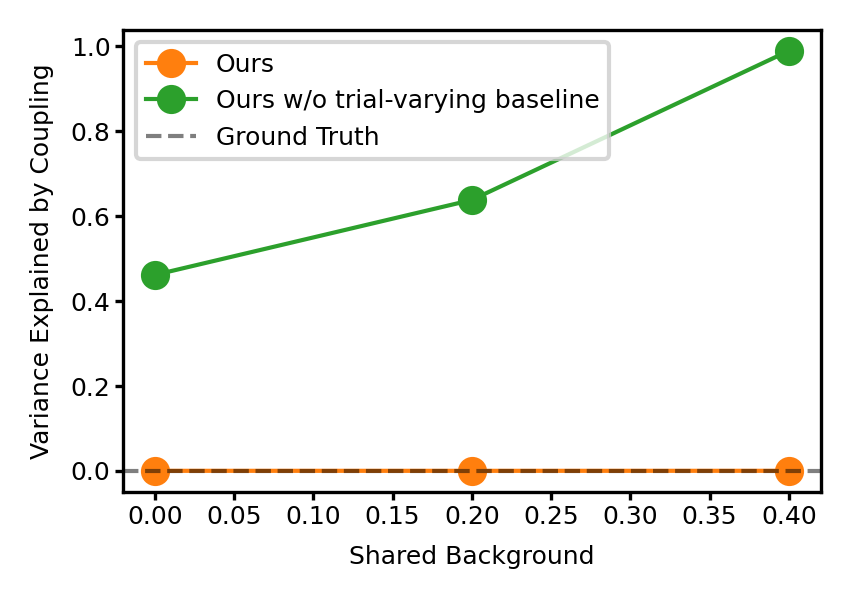

In [ ]:
shared_background_list = [0.0, 0.2, 0.4]

def get_variance_explained_by_coupling_percentage(rcd_for_plot, shared_background):
    firing_rates_total = np.exp(rcd_for_plot[shared_background]['firing_rates_total'])
    firing_rates_wo_coupling = np.exp(rcd_for_plot[shared_background]['firing_rates_total']-rcd_for_plot[shared_background]['firing_rates_coupling'])
    total_variance = firing_rates_total.var(axis=(0,2))
    variance_wo_coupling = firing_rates_wo_coupling.var(axis=(0,2))
    variance_explained_by_coupling = total_variance - variance_wo_coupling
    variance_explained_by_coupling_percentage = variance_explained_by_coupling / total_variance
    print(total_variance.mean(), variance_wo_coupling.mean(), variance_explained_by_coupling.mean())
    return variance_explained_by_coupling_percentage.mean()

fig, ax = plt.subplots(1, 1, figsize=(3, 2), dpi=300)
variance_explained_by_coupling_percentage_list = []
variance_explained_by_coupling_percentage_list_base_model = []

for shared_background in shared_background_list:
    variance_explained_by_coupling_percentage_list.append(get_variance_explained_by_coupling_percentage(rcd_for_plot, shared_background))
    variance_explained_by_coupling_percentage_list_base_model.append(get_variance_explained_by_coupling_percentage(rcd_for_plot_base_model, shared_background))

ax.plot(shared_background_list, variance_explained_by_coupling_percentage_list, 'o-', color='tab:orange', label='Ours')
ax.plot(shared_background_list, variance_explained_by_coupling_percentage_list_base_model, 'o-', color='tab:green', label='Ours w/o trial-varying baseline')
ax.set_xlabel('Shared Background')
ax.set_ylabel('Variance Explained by Coupling')
ax.axhline(0.0, color='k', linestyle='--', alpha=0.5, label='Ground Truth')
ax.legend()

plt.savefig('Figure/Figure4_shared_background.pdf', bbox_inches='tight', dpi=300)